# Analyse de séries temporelles de données satellitaires pour améliorer la prédiction d’indices de sécurité alimentaire

ALIM Yonas 

Encadrant : MADEC Simon , INTERDONATO Roberto
2022


## Sommaire

### Table of Contents

* [1. OBJECTIFS](#chapter1)
* [2. CONTEXTE](#chapter2)
* [3. DATASET](#chapter3)
    * [3.1 PACKAGE](#section_1_1)
    * [3.2 DATA SPATIAL](#section_1_2)
    * [3.3 DATA SCA SDA](#section_1_2)
    * [3.3 FEATURES](#section_1_3)
    * [3.4 REMPLACER SDA SCA MANQUANT](#section_1_4)
* [4. DATA SANITY](#chapter4) 
* [5. DATA VISUALISATION](#chapter5) 
* [6. FEATURES SELECTION](#chapter6)
    * [6.1 MATRICE CORRELATION](#section_6_1)
    * [6.2 VIF](#section_6_2)
* [7. PREPROCESSING](#chapter7)
    * [7.1 CREATION CLASSE](#section_7_1)
    * [7.2 SPLIT TRAIN TEST](#Section_7_2)
* [8. MODELE](#chapter8)
    * [8.1 LOGISTIC REGRESSION](#section_8_1)
    * [8.2 KNN](#section_8_2)  
    * [8.3 DECISION TREE](#section_8_3)
    * [8.4 RANDOM FOREST CLASSIFIER](#section_8_4) 
    * [8.5 GRADIENT BOOSTING CLASSIFIER](#section_8_5)
* [9. PREDICTION](#chapter9)
    * [9.1 Année en fonction d'années](#section_9_1)
    * [9.2 Region en fonction des regions via corrélation](#section_9_2)  
    * [9.3 Region en fonction de Region selon l'emplacement](#section_9_3)
* [10. MODELE DEEP LEARNING](#section_10) 

   


## Objectifs <a class="anchor" id="chapter1"></a>

* Prédiction d’indices de sécurité alimentaire 
    - Prédiction d’une région à partir d’autres régions
    - Prédiction d’une année à partir d’autres année
* Lien entre indicateurs et données

## Contexte <a class="anchor" id="chapter2"></a>

* Problème : Prévenir et répondre à l’apparition de famines
    - Enquêtes compliqués dû au contexte du pays
        - Climatique , démographiques et économique
        - Conflits actuels


* 2 Indicateurs : SCA et SDA
    - SCA : Score de consommation alimentaire
    - SDA : score de diversité alimentaire

**Le score de consommation alimentaire (SCA) (H. Deleglise) :** 

* le SCA est une mesure de l’apport en nutriment et en energie. Il represente une estimation de la frequence cumul ́e de consommation de diff ́erents groupes d’aliments sur 7 jours pour chaque menage interrog ́e. La frequence de consommation de chaque groupe est poder ́e par sa valeur nutritive.

\begin{equation}
 SCA = \sum_{n=1}^{12} xi 
\end{equation}


Formule SDA où $xi$ $\in$ {0 : l’aliment $i$ n’est pas consommé, 1 : l’aliment $i$ est consommé


**Le score de diversit ́e alimentaire des menages (SDA) (H. Deleglise) :**

* le SDA indique le nombre de groupes d’aliment consomm ́ees au cours des dernieres 24 heures et est considere comme une estimation acceptable de la consommation alimentaire. Dans cette etude, nous nous referons aux recommandations de la FAIO et le SDA sera calcul ́e sur la base de 12 groupes d’aliments (cereales ; racines et tubercules; legumes; fruits; produits carnes ; œufs ; poissons et fruits de mer; legumineuses, noix et graines; lait et produits laitiers; huiles et graisses; sucreries; condiments,  ́epices et boissons)

\begin{equation}
 SDA =  \sum_{i=1}^{9} xi.pi 
\end{equation}


Formule SCA où $ xi$ $\in $ Fréquence de consommation pour chaque groupe d’aliments $ i$, $ pi$ $\in$ Poids du groupe d’aliments $i$}

* Données :
    - Séries Spatio-temporelle
    - Granularité différentes ( journalier, hebdomadaires ou mensuel)
    - SCA et SDA disponible en annuel
    - Données de 2009 a 2018


## Dataset <a class="anchor" id="chapter3"></a>

In [1]:
from platform import python_version
print(python_version())

3.6.9


In [2]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

### Import des Packages <a class="anchor" id="#section_1_1"></a>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os 
import keras
import seaborn as sns
import random

Using TensorFlow backend.


Pour commencer il faut creer un dataset à partir des differentes données disponible. 
Dans un premier temps, on se sert des données spatial que l'on va mettre en forme 

### Data Spatial  <a class="anchor" id="#section_1_2"></a>

In [5]:
# Read file

df_ville  = pd.read_csv('village_rural.csv',encoding='latin-1',sep=';')
df_ville = df_ville.filter(items=['REGION', 'PROVINCE', 'COMMUNE', 'region1', 'province1','commune1'])
print("Nombre de commune unique : ",df_ville['commune1'].nunique())

Nombre de commune unique :  352


In [6]:
# dropping ALL duplicate values

df_ville =  df_ville.drop_duplicates(subset=['commune1'])
print("Nombre de commune unique apres drop_duplicates: ",df_ville['commune1'].nunique())

Nombre de commune unique apres drop_duplicates:  352


### Data SCA et SDA <a class="anchor" id="#section_1_3"></a>

Pour les données SCA et SDA, elles sont issues de rapports de differentes années, il faudra donc repeter l'operation avec chaque années. De plus les scores ne sont pas calculer il nous faudra donc les calculer en respectant les formules suivantes

**SCA**

\begin{equation}
 SCA =  \sum_{i=1}^{9} xi.pi 
\end{equation}



 
  xi ∈ {Fréquence de consommation pour chaque groupe d’aliments i}, pi ∈ {Poids du groupe d’aliments i}

 
 
 | Groupe d’aliments |  Poids ( valeur Nutri)  | data|
 |:-----------------------:|:---:|:---:|
 | Céréales et tubercules  |  2  | NBR_CONS_CER  |
|      Légumineuses       |  3  | NBR_CONS_LEG  |
|   Légumes et feuilles   |  1  |  NBR_CONS_LEG_VITA + NBR_CONS_AULEGUM   +  NBR_CONS_FEUIL |
|         Fruits          |  1  | NBR_CONS_FR_VITA + NBR_CONS_AUTFRUI|
|   Protéines animales    |  4  | NBR_CONS_VIANDE  |
|    Produits laitiers    |  4  | NBR_CONS_LAIT  |
|         Sucres          | 0.5 | NBR_CONS_SUCR  |
|         Huiles          | 0.5 | NBR_CONS_HUIL |
|       Condiments        |  0  | NBR_CONS_COND  |
 
 
 

 
 






**SDA**

\begin{equation}
 SDA = \sum_{n=1}^{12} xi 
\end{equation}

 xi ∈ {0 : l’aliment i n’est pas consommé, 1 : l’aliment i est consommé}

 
 
 Calculé sur la base de 12 groupes d’aliments :
 



 | Groupe d’aliments | data  |
 |:-----------------------:|:---:|
 | Céréales   |  NBR_CONS_CER  | 
 | racines et tubercules ;       |  NBR_CONS_RAC |
|   Légumes    | NBR_CONS_LEG  + NBR_CONS_AUTLEG| 
|    Fruits          |  NBR_CONS_FR_VITA + NBR_CONS_AUTFRUI  | 
|   produits carnés   |  VIANDE +  foie   | 
|    œufs ;    |  NBR_CONS_OEUF  | 
|        poissons et fruits de mer           | NBR_CONS_POIS | 
|         légumineuses          | NBR_CONS_LEG | 
|       noix et graines        |  NBR_CONS_OLEA | 
|         ait et produits laitiers ;          | NBR_CONS_LAIT | 
|         huiles et graisses ;          | NBR_CONS_HUIL |
|          sucreries ;           | NBR_CONS_SUCR | 
|         condiments          |NBR_CONS_COND | 
|         épices          | ? |
|         boissons          | NBR_CONS_BOIS | 

In [7]:
df_2009  = pd.read_csv('C6.1_2009_2017.csv',encoding='latin-1',sep=';')

###rename pour le join apres avec les données spatial

df_2009  =  df_2009.rename(columns={"REG": "REGION", 
                                    "PROV": "PROVINCE",
                                    "COM": "COMMUNE",              })




In [8]:
### Merge données pour obtenir un dataset qui contient sca sda + nom region provinces communes

df_join =  pd.merge(df_2009, df_ville, on=['REGION','PROVINCE','COMMUNE'])

### Creation d'un dataset tampon pour le calcul 
df_cal = df_join

print("Nombre de commune unique apres merge: ",df_cal.commune1.nunique())

Nombre de commune unique apres merge:  343


In [9]:
##### SCA

df_cal['SCA']=(

            ((df_cal["NBR_CONS_CER"]+df_cal["NBR_CONS_RAC"]) * 2) + 
            ((df_cal["NBR_CONS_LEG"] + df_cal["NBR_CONS_OLEA"]  )* 3) + 
            ((df_cal["NBR_CONS_LEG_VITA"]+ df_cal["NBR_CONS_AUTLEG"] +  df_cal["NBR_CONS_FEUIL"]  ) * 1) + 
            ((df_cal["NBR_CONS_FR_VITA"]+ df_cal["NBR_CONS_AUTFRUI"]) *1) + 
            ((df_cal["NBR_CONS_VIAND"]+df_cal["NBR_CONS_FOI"]+df_cal["NBR_CONS_OEUF"]+df_cal["NBR_CONS_POIS"])*4) +
            (df_cal["NBR_CONS_LAIT"] *4) + 
            ((df_cal["NBR_CONS_SUCR"]+ df_cal["NBR_CONS_BOIS"] )  *0.5 )+ 
            ((df_cal["NBR_CONS_HUIL"]) *0.5)+
            (df_cal["NBR_CONS_COND"] * 0 )
)

In [10]:
####  SDA 

#Creation d'une colone vide
df_cal['SDA']=0 

### in range 1 -> 7 car cest par jour de la semaine ( lundi -> dimanche )
for i in range(1,8):
    
    df_cal[f"NBR_CONS_CER{i}_sda"] = df_cal[f"CONS_CER{i}"].apply(lambda x: 0 if x == 0 else 1)

    df_cal[f"NBR_CONS_RAC{i}_sda"] = df_cal[f"CONS_RACTUB{i}"].apply(lambda x: 0 if x == 0 else 1)

    df_cal[f"NBR_CONS_LEG{i}_sda"] = df_cal[f"CONS_LEGUMIN{i}"].apply(lambda x: 0 if x == 0 else 1)
    df_cal[f"NBR_CONS_AUTLEG{i}_sda"] = df_cal[f"CONS_AUTLEGUM{i}"].apply(lambda x: 0 if x == 0 else 1)
    df_cal[f"NBR_CONS_FEUIL{i}_sda"] = df_cal[f"CONS_FEUILLE{i}"].apply(lambda x: 0 if x == 0 else 1)

    df_cal[f"NBR_CONS_FR_VITA{i}_sda"] = df_cal[f"CONS_FRUIT{i}"].apply(lambda x: 0 if x == 0 else 1)
    df_cal[f"NBR_CONS_AUTFRUI{i}_sda"] = df_cal[f"CONS_AUTRFRU{i}"].apply(lambda x: 0 if x == 0 else 1)



    df_cal[f"NBR_CONS_VIAND{i}_sda"] = df_cal[f"CONS_VIANDE{i}"].apply(lambda x: 0 if x == 0 else 1)
    df_cal[f"NBR_CONS_FOI{i}_sda"] = df_cal[f"CONS_FOIE{i}"].apply(lambda x: 0 if x == 0 else 1)

    df_cal[f"NBR_CONS_OEUF{i}_sda"] = df_cal[f"CONS_OEUF{i}"].apply(lambda x: 0 if x == 0 else 1)

    df_cal[f"NBR_CONS_POIS{i}_sda"] = df_cal[f"CONS_POISSON{i}"].apply(lambda x: 0 if x == 0 else 1)
    df_cal[f"NBR_CONS_LEG{i}_sda"] = df_cal[f"CONS_LEGUM{i}"].apply(lambda x: 0 if x == 0 else 1)
    df_cal[f"NBR_CONS_OLEA{i}_sda"] = df_cal[f"CONS_OLEA{i}"].apply(lambda x: 0 if x == 0 else 1)
    df_cal[f"NBR_CONS_LAIT{i}_sda"] = df_cal[f"CONS_LAIT{i}"].apply(lambda x: 0 if x == 0 else 1)
    df_cal[f"NBR_CONS_HUIL{i}_sda"] = df_cal[f"CONS_HUILE{i}"].apply(lambda x: 0 if x == 0 else 1)
    df_cal[f"NBR_CONS_SUCR{i}_sda"] = df_cal[f"CONS_SUCRE{i}"].apply(lambda x: 0 if x == 0 else 1)
    df_cal[f"NBR_CONS_COND{i}_sda"] = df_cal[f"CONS_CONDIMENT{i}"].apply(lambda x: 0 if x == 0 else 1)
    df_cal[f"NBR_CONS_BOIS{i}_sda"] = df_cal[f"CONS_BOISS{i}"].apply(lambda x: 0 if x == 0 else 1)
    

for i in range(1,8):
    
    df_cal[f"SDA{i}"]= (
                df_cal[f"NBR_CONS_CER{i}_sda"] + 
                df_cal[f"NBR_CONS_RAC{i}_sda"] +
                df_cal[[f"NBR_CONS_LEG{i}_sda",f"NBR_CONS_AUTLEG{i}_sda",f"NBR_CONS_FEUIL{i}_sda"]].max(axis =1)+
                df_cal[[f"NBR_CONS_FR_VITA{i}_sda",f"NBR_CONS_AUTFRUI{i}_sda"]].max(axis =1) +
                df_cal[[f"NBR_CONS_FOI{i}_sda",f"NBR_CONS_FOI{i}_sda"]].max(axis =1) +
                df_cal[f"NBR_CONS_OEUF{i}_sda"] +
                df_cal[f"NBR_CONS_POIS{i}_sda"] +
                df_cal[[f"NBR_CONS_LEG{i}_sda",f"NBR_CONS_OLEA{i}_sda"]].max(axis =1)  + 
                df_cal[f"NBR_CONS_LAIT{i}_sda"]+
                df_cal[f"NBR_CONS_HUIL{i}_sda"] +
                df_cal[f"NBR_CONS_SUCR{i}_sda"] + 
                df_cal[f"NBR_CONS_COND{i}_sda"]+
                df_cal[f"NBR_CONS_BOIS{i}_sda"] )
    
    
    
df_cal["SDA"]= (df_cal["SDA1"]+df_cal["SDA2"]+df_cal["SDA3"]+df_cal["SDA4"]+df_cal["SDA5"]+df_cal["SDA6"]+df_cal["SDA7"])/7
print('Done')

Done


In [11]:
#Group by et moyenne par année pour chaque commune

df_cal.drop(['REGION', 'PROVINCE','COMMUNE'], axis=1, inplace=True)
df_cal.rename(columns = {'region1':'REGION', 'province1':'PROVINCE','commune1':'COMMUNE'}, inplace = True)
df_final = df_cal.groupby(['ANNEE','REGION','PROVINCE','COMMUNE']).mean()

df= df_final.filter(items=['REGION', 'PROVINCE',
       'COMMUNE',"SCA" , "SDA"])

df

SCA       SDA
ANNEE REGION           PROVINCE COMMUNE                      
2009  BOUCLE DU MOUHOU BALE     BAGASSI   64.540000  5.508571
                                BANA      52.333333  5.038095
                                BOROMO    60.500000  4.914286
                                FARA      79.120690  6.152709
                                OURY      72.312500  5.535714
...                                             ...       ...
2017  SUD OUEST        PONI     KAMPTI    54.333333  5.182540
                                LOROPENI  74.500000  5.781513
                                MALBA     66.750000  5.928571
                                NAKO      47.875000  4.964286
                                PERIGBAN  30.500000  3.023810

[2735 rows x 2 columns]

In [12]:
### Verification afin de voir si aucune commune n'a disparu entre temps

df = df.reset_index()
print("Nombre de commune unique à la fin du dataset: ",df.COMMUNE.nunique())


Nombre de commune unique à la fin du dataset:  343


In [13]:
data_2009_17 = pd.read_csv('data_2009-17.csv')  
data_2018 = pd.read_csv('data_2018.csv') 
data_2019 = pd.read_csv('data_2019.csv') 
data_2020 = pd.read_csv('data_2020.csv') 

data_rep = pd.read_excel('rep_epa_2009-2018.xlsx',engine='openpyxl')

In [14]:
### Chaque année possede un nombre de commune different

print('data_2009_17( temperature, pluie, evapotranspi ) :',data_2009_17.COMMUNE.nunique())
print('DATA data_2018 sda :',data_2018.COMMUNE.nunique())
print('DATA data_2019 sda :',data_2019.COMMUNE.nunique())
print('DATA data_2020 sda :',data_2020.COMMUNE.nunique())

data_2009_17( temperature, pluie, evapotranspi ) : 343
DATA data_2018 sda : 316
DATA data_2019 sda : 312
DATA data_2020 sda : 264


In [15]:
# Certaine communes sont presentes dans les deux dataset mais possede des noms diferents
##Liste des communes differentes entres les années
lsca = data_2009_17.COMMUNE.unique().tolist()
lsim = data_2018.COMMUNE.unique().tolist()
diff = []
lsim.sort()
lsca.sort()

diff = []
for i in range(len(lsca)):
    if lsca[i] not in lsim:
        diff.append(lsca[i])
        
        
print(len(diff))
diff.sort()
diff

27


['DASSA',
 'DOUNA',
 'DOUROULA',
 'DOURTENGA',
 'GOMBORO',
 'IMASGHO',
 'IPELCE',
 'KOMTOEGA',
 'KOSSOUKA',
 'KYON',
 'NAMISSIGUIMA',
 'NAMOUNOU',
 'OUAGADOUGOU- SIG-NON',
 'OUAGADOUGOU-NONGREMA',
 'OURSI',
 'PIBAORE',
 'POURA',
 'ROLLO',
 'SABOU',
 'SATIRI',
 'SOURGOU',
 'TENSOBENTENGA',
 'TOUSSIANA',
 'WOLONKOTO',
 'YAMBA',
 'ZAMO',
 'ZOAGA']

Utilisation de SequenceMatcher pour determiner les differences entre les ecritures pour les communes ( accents, tiret etc.) et pouvoir verifier si il sagit de communes identiques ou non.

Possibilité d'utiliser la distance de levenshtein ou soundex

In [16]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [17]:
### Faire attention car dans certains cas le score est elevé mais ce nest pas la bonne region 
for i in range(len(lsca)):
    for j in range(len(lsim)):
        if  lsca[i] in diff:
            
            if similar(lsca[i],lsim[j]) >= 0.75:
                print(lsca[i]," ---->  : ",lsim[j],similar(lsca[i],lsim[j]),)
                             
print("DONE")

DOUNA  ---->  :  NOUNA 0.8
DOUROULA  ---->  :  KOUROUMA 0.75
DOUROULA  ---->  :  N'DOROLA 0.75
DOURTENGA  ---->  :  POUYTENGA 0.7777777777777778
GOMBORO  ---->  :  GBOMBLORA 0.75
KOSSOUKA  ---->  :  KOUKA 0.7692307692307693
KYON  ---->  :  KONA 0.75
POURA  ---->  :  BOURA 0.8
POURA  ---->  :  POA 0.75
SOURGOU  ---->  :  SOURGOUBILA 0.7777777777777778
TOUSSIANA  ---->  :  GOSSINA 0.75
YAMBA  ---->  :  SAMBA 0.8
YAMBA  ---->  :  YABA 0.8888888888888888
ZAMO  ---->  :  ZAM 0.8571428571428571
ZAMO  ---->  :  ZAMBO 0.8888888888888888
DONE


In [18]:
data_2009_17.loc[data_2009_17['COMMUNE'] == "ZAMO"]

,ANNEE,REGION,PROVINCE,COMMUNE,SCA,SDA
133,2009,CENTRE OUEST,SANGUIE,ZAMO,82.1,5.142857
432,2010,CENTRE OUEST,SANGUIE,ZAMO,99.2,6.485714
727,2011,CENTRE OUEST,SANGUIE,ZAMO,107.1,6.914286
1012,2012,CENTRE OUEST,SANGUIE,ZAMO,101.9,6.828571
1313,2013,CENTRE OUEST,SANGUIE,ZAMO,113.5,7.514286


In [19]:
data_2018.loc[data_2018['COMMUNE'] == "ZAMBO"]

,ANNEE,REGION,PROVINCE,COMMUNE,SCA,SDA
301,2018,SUD OUEST,IOBA,ZAMBO,50.027778,4.785714


In [20]:
frames = [data_2009_17, data_2018, data_2019,data_2020]
result = pd.concat(frames)

In [21]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3627 entries, 0 to 263
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ANNEE     3627 non-null   int64  
 1   REGION    3627 non-null   object 
 2   PROVINCE  3627 non-null   object 
 3   COMMUNE   3627 non-null   object 
 4   SCA       3624 non-null   float64
 5   SDA       3627 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 198.4+ KB


In [22]:
### Certaines colonnes possede des NaN on verifie donc lesquelles
is_NaN = result. isnull()
row_has_NaN = is_NaN. any(axis=1)
rows_with_NaN = result[row_has_NaN]
print(rows_with_NaN)

    ANNEE       REGION PROVINCE   COMMUNE  SCA        SDA
64   2019   CENTRE EST  BOULGOU     BAGRE  NaN  11.142857
93   2019  CENTRE NORD      BAM     SABCE  NaN  11.142857
95   2019  CENTRE NORD      BAM  ZIMTENGA  NaN  11.142857


In [23]:
### drop les NA

result.dropna()
###result.to_csv("data_sca_sda.csv", index=False)
print()

### Features <a class="anchor" id="#section_1_4"></a>

On va ajouter les données satelitaire qu'on utilisera en tant que Features 

In [24]:
### On charge les données depuis les CSV

data_sim2 = pd.read_csv('dataExtraERA5ForYonas_v3105.csv')
data_sca = pd.read_csv('data_sca_sda.csv')
data_vci_vhi = pd.read_csv('data_vhi_vci.csv')
data_sim= pd.read_csv('dataERA5ForYonas.csv')
data_ndvi=  pd.read_csv('dataNDVI.csv')

##drop columns non utile
data_vci_vhi = data_vci_vhi.drop(columns=['year-dekad', 'fullname','season'])

##rename pour plus tard
data_sim.rename(columns = {'region':'REGION', 'province':'PROVINCE', 'commune':'COMMUNE'}, inplace = True)
data_vci_vhi.rename(columns = {'region':'REGION', 'province':'PROVINCE', 'commune':'COMMUNE'}, inplace = True)
data_sim2.rename(columns = {'region':'REGION', 'province':'PROVINCE', 'commune':'COMMUNE'}, inplace = True)
data_ndvi.rename(columns = {'region':'REGION', 'province':'PROVINCE', 'commune':'COMMUNE'}, inplace = True)

/home/yonas/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [25]:
##Creation colone Annee et mois
data_ndvi["ANNEE"] = data_ndvi['date'].str.slice(0, 4)
data_ndvi["MOIS"] = data_ndvi['date'].str.slice(5, 7)

data_vci_vhi["ANNEE"] = data_vci_vhi['date'].str.slice(0, 4)
data_vci_vhi["MOIS"] = data_vci_vhi['date'].str.slice(5, 7)

data_sim["ANNEE"] = data_sim['date'].str.slice(0, 4)
data_sim["MOIS"] = data_sim['date'].str.slice(5, 7)

data_sim2["ANNEE"] = data_sim2['date'].str.slice(0, 4)
data_sim2["MOIS"] = data_sim2['date'].str.slice(5, 7)

In [26]:
## Separe en petit Dataset pour obtenir le format desirée par la suite



df_ndvi = data_ndvi[data_ndvi.variable == "NDVI"]
df_ndvi = df_ndvi.drop(columns=[ 'variable'])
df_ndvi.rename(columns = {'values':'NDVI'}, inplace = True)


df_vhi = data_vci_vhi[data_vci_vhi.variable == "VHI"]
df_vci = data_vci_vhi[data_vci_vhi.variable == "VCI"]
df_asi = data_vci_vhi[data_vci_vhi.variable == "ASI"]


df_vhi = df_vhi.drop(columns=[ 'variable'])
df_vci = df_vci.drop(columns=[ 'variable'])
df_asi = df_asi.drop(columns=[ 'variable'])


df_vhi.rename(columns = {'values':'VHI'}, inplace = True)
df_vci.rename(columns = {'values':'vci'}, inplace = True)
df_asi.rename(columns = {'values':'ASI'}, inplace = True)

df_temp = data_sim[data_sim.variable == "Temperature @2m"]
df_tmax = data_sim[data_sim.variable == "Temperature max"]
df_tmin = data_sim[data_sim.variable == "Temperature min"]
df_pluie = data_sim[data_sim.variable == "Total precipitation"]
df_evapo = data_sim[data_sim.variable == "Evapostranspiration"]

df_temp = df_temp.drop(columns=[ 'variable'])
df_tmax = df_tmax.drop(columns=[ 'variable'])
df_tmin = df_tmin.drop(columns=[ 'variable'])
df_pluie = df_pluie.drop(columns=[ 'variable'])
df_evapo = df_evapo.drop(columns=[ 'variable'])

df_temp.rename(columns = {'values':'T'}, inplace = True)
df_tmax.rename(columns = {'values':'TMAX'}, inplace = True)
df_tmin.rename(columns = {'values':'TMIN'}, inplace = True)
df_pluie.rename(columns = {'values':'PLUIE'}, inplace = True)
df_evapo.rename(columns = {'values':'EVAPO'}, inplace = True)


df_LAIHV = data_sim2[data_sim2.variable == "Leaf Area Index High Vegetation"]
df_LAILV = data_sim2[data_sim2.variable == "Leaf Area Index Low Vegetation"]
df_SOILT1 = data_sim2[data_sim2.variable == "Soil Temperature Level 1"]
df_SOILT2 = data_sim2[data_sim2.variable == "Soil Temperature Level 2"]
df_SOILT3 = data_sim2[data_sim2.variable == "Soil Temperature Level 3"]
df_SOILT4 = data_sim2[data_sim2.variable == "Soil Temperature Level 4"]

df_LAIHV = df_LAIHV.drop(columns=[ 'variable'])
df_LAILV = df_LAILV.drop(columns=[ 'variable'])
df_SOILT1 = df_SOILT1.drop(columns=[ 'variable'])
df_SOILT2 = df_SOILT2.drop(columns=[ 'variable'])
df_SOILT3 = df_SOILT3.drop(columns=[ 'variable'])
df_SOILT4 = df_SOILT4.drop(columns=[ 'variable'])

df_LAIHV.rename(columns = {'values':'LAIHV'}, inplace = True)
df_LAILV.rename(columns = {'values':'LAILV'}, inplace = True)
df_SOILT1.rename(columns = {'values':'SOILT1'}, inplace = True)
df_SOILT2.rename(columns = {'values':'SOILT2'}, inplace = True)
df_SOILT3.rename(columns = {'values':'SOILT3'}, inplace = True)
df_SOILT4.rename(columns = {'values':'SOILT4'}, inplace = True)

In [27]:
### Le NDVI n'est pas recuperer les memes jours  ni avec la meme granularité que les autres variables 
### On prepare donc le dataset pour la suite avec le merge


df_ndvi = df_ndvi.drop(columns=['date'])
df_ndvi = df_ndvi.groupby(['ANNEE', 'MOIS','REGION', 'PROVINCE','COMMUNE']).mean()
df_ndvi

NDVI
ANNEE MOIS REGION            PROVINCE COMMUNE              
2010  01   BOUCLE DU MOUHOUN BALÉ     BAGASSI   2469.102104
                                      BANA      2751.603095
                                      BOROMO    2844.346659
                                      FARA      2670.447777
                                      OURY      2616.355828
...                                                     ...
2021  12   SUD-OUEST         PONI     KAMPTI    4113.249478
                                      LOROPENI  4220.873525
                                      MALBA     3229.253117
                                      NAKO      3265.006917
                                      PERIGBAN  3834.948849

[50544 rows x 1 columns]

In [28]:
### On merge tout les petit dataset afin d'obtenir un grand dataset avec chaque features pour chaques commune par mois

data_join_expect_sca = df_vhi.merge(df_vci,  on=['date','COMMUNE','PROVINCE','REGION','ANNEE','MOIS'])
data_join_expect_sca = data_join_expect_sca.merge(df_temp, on=['date','COMMUNE','PROVINCE','REGION','ANNEE','MOIS'])
data_join_expect_sca = data_join_expect_sca.merge(df_tmax, on=['date','COMMUNE','PROVINCE','REGION','ANNEE','MOIS'])
data_join_expect_sca = data_join_expect_sca.merge(df_tmin, on=['date','COMMUNE','PROVINCE','REGION','ANNEE','MOIS'])
data_join_expect_sca = data_join_expect_sca.merge(df_pluie,  on=['date','COMMUNE','PROVINCE','REGION','ANNEE','MOIS'])
data_join_expect_sca = data_join_expect_sca.merge(df_evapo,  on=['date','COMMUNE','PROVINCE','REGION','ANNEE','MOIS'])
data_join_expect_sca = data_join_expect_sca.merge(df_LAIHV,  on=['date','COMMUNE','PROVINCE','REGION','ANNEE','MOIS'])
data_join_expect_sca = data_join_expect_sca.merge(df_LAILV,  on=['date','COMMUNE','PROVINCE','REGION','ANNEE','MOIS'])
data_join_expect_sca = data_join_expect_sca.merge(df_SOILT1,  on=['date','COMMUNE','PROVINCE','REGION','ANNEE','MOIS'])
data_join_expect_sca = data_join_expect_sca.merge(df_SOILT2,  on=['date','COMMUNE','PROVINCE','REGION','ANNEE','MOIS'])
data_join_expect_sca = data_join_expect_sca.merge(df_SOILT3,  on=['date','COMMUNE','PROVINCE','REGION','ANNEE','MOIS'])
data_join_expect_sca = data_join_expect_sca.merge(df_SOILT4, on=['date','COMMUNE','PROVINCE','REGION','ANNEE','MOIS'])


In [29]:
### On drop la date car on a maintenant les colonnes mois et année 
### On utilise un mean pour obtenir nos  valeurs par mois car certaines 
## données possedent des granularité differentes (hebdomadaire)

data_join_expect_sca = data_join_expect_sca.drop(columns=['date'])
data_join_expect_sca = data_join_expect_sca.groupby(['ANNEE', 'MOIS','REGION', 'PROVINCE','COMMUNE']).mean()
data_join_expect_sca = data_join_expect_sca.merge(df_ndvi,  on=['REGION','PROVINCE','COMMUNE','ANNEE','MOIS'])
data_join_expect_sca

VHI       vci          T  \
REGION            PROVINCE COMMUNE  ANNEE MOIS                                  
BOUCLE DU MOUHOUN BALÉ     BAGASSI  2010  01    3.719003  7.219751  26.650786   
                           BANA     2010  01    3.903945  7.838469  27.111111   
                           BOROMO   2010  01    4.064707  7.917159  27.059259   
                           FARA     2010  01    4.151389  7.913513  27.401389   
                           OURY     2010  01    3.823146  7.861898  26.792593   
...                                                  ...       ...        ...   
SUD-OUEST         PONI     KAMPTI   2020  12    4.083251  6.927070  27.902084   
                           LOROPENI 2020  12    4.809317  7.586780  27.751388   
                           MALBA    2020  12    3.644857  6.306612  28.300000   
                           NAKO     2020  12    3.399793  6.247997  28.314815   
                           PERIGBAN 2020  12    3.865247  6.768488  27.907407   

                                                     TMAX       TMIN  \
REGION            PROVINCE COMMUNE  ANNEE MOIS                         
BOUCLE DU MOUHOUN BALÉ     BAGASSI  2010  01    29.560092  23.551974   
                           BANA     2010  01    34.700000  18.200000   
                           BOROMO   2010  01    35.097221  17.675000   
                           FARA     2010  01    35.599535  18.362500   
                           OURY     2010  01    34.588889  17.408642   
...                                                   ...        ...   
SUD-OUEST         PONI     KAMPTI   2020  12    34.769444  21.207638   
                           LOROPENI 2020  12    34.662500  21.008024   
                           MALBA    2020  12    35.327778  20.877778   
                           NAKO     2020  12    35.401853  20.812963   
                           PERIGBAN 2020  12    34.792590  21.218519   

                                                   PLUIE     EVAPO     LAIHV  \
REGION            PROVINCE COMMUNE  ANNEE MOIS                                 
BOUCLE DU MOUHOUN BALÉ     BAGASSI  2010  01    1.137476  6.850287  1.491323   
                           BANA     2010  01    0.000000  9.588889  0.166667   
                           BOROMO   2010  01    0.000000  9.374074  0.269444   
                           FARA     2010  01    0.000000  9.428241  0.715278   
                           OURY     2010  01    0.000000  9.412346  0.529630   
...                                                  ...       ...       ...   
SUD-OUEST         PONI     KAMPTI   2020  12    0.000000  8.133333  3.182639   
                           LOROPENI 2020  12    0.000000  8.202623  2.545525   
                           MALBA    2020  12    0.000000  8.316667  1.750000   
                           NAKO     2020  12    0.000000  8.406944  2.152778   
                           PERIGBAN 2020  12    0.000000  8.185185  1.411111   

                                                   LAILV      SOILT1  \
REGION            PROVINCE COMMUNE  ANNEE MOIS                         
BOUCLE DU MOUHOUN BALÉ     BAGASSI  2010  01    1.062442  300.117073   
                           BANA     2010  01    1.300000  302.488890   
                           BOROMO   2010  01    1.300000  302.392597   
                           FARA     2010  01    1.300000  303.056943   
                           OURY     2010  01    1.264197  301.970380   
...                                                  ...         ...   
SUD-OUEST         PONI     KAMPTI   2020  12    1.504398  303.677083   
                           LOROPENI 2020  12    1.524537  303.045377   
                           MALBA    2020  12    1.405556  303.538887   
                           NAKO     2020  12    1.406944  303.479630   
                           PERIGBAN 2020  12    1.483951  303.585173   

                                                    SOILT2      SOILT3  \
REGION    

In [30]:
### On observe le nombre de communes dans notre dataset features et dataset SDA/SCA avant le merge
data_join_expect_sca = data_join_expect_sca.reset_index()
print('data_join_expect_sca( temperature, pluie, evapotranspi ) :',data_join_expect_sca.COMMUNE.nunique())
print('DATA sca sda :',data_sca.COMMUNE.nunique())


data_join_expect_sca( temperature, pluie, evapotranspi ) : 349
DATA sca sda : 347


In [31]:
### On observe si les communes des deux dataset sont les memes

lsca = data_sca.COMMUNE.unique().tolist()
lsim = data_join_expect_sca.COMMUNE.unique().tolist()

diff = []
lsim.sort()
lsca.sort()

for i in range(len(lsca)):
    for j in range(len(lsim)):
        if  lsca[i] in diff:
            
            if similar(lsca[i],lsim[j]) >= 0.75:
                print(lsca[i]," ---->  : ",lsim[j],similar(lsca[i],lsim[j]),)
                ###lsim[j] =  lsca[i]
                ###data_sca["COMMUNE"] = data_sca["COMMUNE"].replace([lsca[i]], lsim[i])
                ###print("swap is done")

                
print("DONE")

DONE


In [32]:
## Exemple 
data_sca[data_sca['COMMUNE'] == 'SIDERADOUGOU']

,ANNEE,REGION,PROVINCE,COMMUNE,SCA,SDA
48,2009,CASCADES,COMOE,SIDERADOUGOU,62.166667,5.457143
349,2010,CASCADES,COMOE,SIDERADOUGOU,49.750000,5.271429
643,2011,CASCADES,COMOE,SIDERADOUGOU,63.200000,5.514286
932,2012,CASCADES,COMOE,SIDERADOUGOU,59.700000,5.228571
1229,2013,CASCADES,COMOE,SIDERADOUGOU,61.000000,4.742857
1528,2014,CASCADES,COMOE,SIDERADOUGOU,70.791667,5.309524
1840,2015,CASCADES,COMOE,SIDERADOUGOU,70.608696,5.838509
2152,2016,CASCADES,COMOE,SIDERADOUGOU,64.083333,5.273810
2468,2017,CASCADES,COMOE,SIDERADOUGOU,49.750000,4.642857
2784,2018,CASCADES,COMOE,SIDERADOUGOU,58.270833,4.964286


In [33]:
## Exemple 
data_join_expect_sca[data_join_expect_sca['COMMUNE'] == 'SOUBAKANIÉDOUGOU']

,REGION,PROVINCE,COMMUNE,ANNEE,MOIS,VHI,vci,T,TMAX,TMIN,PLUIE,EVAPO,LAIHV,LAILV,SOILT1,SOILT2,SOILT3,SOILT4,NDVI
54,CASCADES,COMOÉ,SOUBAKANIÉDOUGOU,2010,01,4.028340,7.836381,26.563703,34.137038,18.647037,0.000000,9.181111,3.016296,1.481111,300.955547,299.484823,300.205567,300.943350,3361.070103
405,CASCADES,COMOÉ,SOUBAKANIÉDOUGOU,2010,02,4.686962,7.812591,29.773704,37.358521,22.665925,0.000000,9.849629,3.014444,1.449630,305.644060,303.690017,302.441503,301.055560,3464.242627
756,CASCADES,COMOÉ,SOUBAKANIÉDOUGOU,2010,03,5.456363,4.994190,32.007777,37.895558,26.206667,0.034444,9.113333,3.018148,1.539630,309.685923,307.323357,305.548493,302.503340,3626.105979
1107,CASCADES,COMOÉ,SOUBAKANIÉDOUGOU,2010,04,4.493154,4.786710,31.814444,37.596297,24.993333,0.261481,8.916668,3.053333,1.666667,308.341113,306.671860,306.168877,304.292597,4086.283712
1458,CASCADES,COMOÉ,SOUBAKANIÉDOUGOU,2010,05,5.525252,6.393365,29.355184,35.327778,24.581852,9.662592,8.161852,3.056667,1.798889,306.382583,304.958517,304.776657,304.774453,5595.362913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44631,CASCADES,COMOÉ,SOUBAKANIÉDOUGOU,2020,08,2.397570,5.156956,24.507037,26.788518,22.321111,13.416666,3.035926,3.060000,1.957037,299.159993,299.554433,300.557770,302.587037,4705.227298
44982,CASCADES,COMOÉ,SOUBAKANIÉDOUGOU,2020,09,3.312287,4.278116,25.508889,28.978890,21.302963,4.399259,4.897778,3.068889,2.168148,299.376697,298.972587,299.734823,301.258140,6336.289105
45333,CASCADES,COMOÉ,SOUBAKANIÉDOUGOU,2020,10,3.604542,5.885584,25.755556,29.434074,22.614443,28.227406,5.015185,3.068889,2.177778,300.738890,300.393700,300.534073,300.678160,6110.993910
45684,CASCADES,COMOÉ,SOUBAKANIÉDOUGOU,2020,11,2.268040,6.149378,27.634445,33.358520,19.689259,0.000000,8.280740,3.058889,1.925555,302.217780,300.942973,300.959617,300.703347,4602.740609


In [34]:
### Afin de ne pas faire d'erreur sur les communes ou les resultats de la fonction similar ne sont pas sur a 100% 

## On fini de remplacer les nom a la main grace a laffichage presenter precedement tout en verifiant si les regions et provinces 
## correspondent 

data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("POMPOI", "POMPOÏ")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("BALAVE", "BALAVÉ")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("TCHERIBA", "TCHÉRIBA")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("LANFIERA", "LANFIÈRA")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("LANKOUE", "LANKOUÈ")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("SIDERADOUGOU", "SOUBAKANIÉDOUGOU")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("TIEFORA", "TIÉFORA")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("TANGHIN DASSOURI", "TANGHIN-DASSOURI")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("NIAOGO", "NIAOGHO")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("ZABRE", "ZABRÉ")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("SANHA", "SANGHA")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("YONDE", "YONDÉ")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("KOUPELA", "KOUPÉLA")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("BOGANDE", "BOGANDÉ")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("PIELA", "PIÉLA")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("BARTIBOUGOU", "BARTIÉBOUGOU")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("GAYERI", "GAYÉRI")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("BOBO DIOULASSO", "BOBO-DIOULASSO")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("DANDE", "DANDÉ")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("KARANKASSO SAMBLA", "KARANKASSO-SAMBLA")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("KARANKASSO-VIGUE", "KARANKASSO-VIGUÉ")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("PADEMA", "PADÉMA")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("BONY", "BONI")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("KOURIGNON", "KOURINION")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("HOUNDE", "HOUNDÉ")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("ARBOLE", "ARBOLLE")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("LA-TODIN", "LÂ-TODIN")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("MEGUET", "MÉGUET")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("MOGTEDO", "MOGTÉDO")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("BOUSSE", "BOUSSÉ")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("TOEGHIN", "TOÉGHIN")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("DAPELOGO", "DAPÉLOGO")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("ARBINDA", "ARIBINDA")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("BATIE", "BATIÉ")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("DJIGOUE", "DJIGOUÈ")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("COALLA", "KOALLA")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("ZONSE", "ZONSÉ")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("LEBA", "LÉBA")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("KPUERE", "KPUÉRÉ")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("REO", "RÉO")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("SOUBAKANIEDOUGOU", "SOUBAKANIÉDOUGOU")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("TIEBELE", "TIÉBÉLÉ")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("TO", "TÔ")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("Kokologo", "KOKOLOGHO")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("TO", "TÔ")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("Kokologo", "KOKOLOGHO")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("OUAGADOUGOU- SIG-NON", "OUAGADOUGOU")
data_sca["COMMUNE"] = data_sca["COMMUNE"].replace("OUAGADOUGOU-NONGREMA", "OUAGADOUGOU")

In [35]:
## On observe la difference entre le dataset features et le dataset sca sda encore une fois afin de verifier que tout est bon

lsca = data_sca.COMMUNE.unique().tolist()
lsim = data_join_expect_sca.COMMUNE.unique().tolist()
diff = []
lsim.sort()
lsca.sort()

diff = []
for i in range(len(lsca)):
    if lsca[i] not in lsim:
        diff.append(lsca[i])
        
        
print(len(diff))
diff.sort()
diff

0


[]

In [36]:
### On ajoute le TCI calculé avec la formule TCI = 100 * (Tmax - T) / (Tmax – Tmin)

In [37]:
data_join_expect_sca["TCI"]= 100* (data_join_expect_sca["TMAX"] - data_join_expect_sca["T"]) / (data_join_expect_sca["TMAX"] - data_join_expect_sca["TMIN"])

In [38]:
### On transforme les soilt1 2 3 4 en une seul features qui correspond a la moyenne. 


data_join_expect_sca["SOILT"] = ( data_join_expect_sca["SOILT1"] +
                                    data_join_expect_sca["SOILT2"] +
                                    data_join_expect_sca["SOILT3"]+
                                    data_join_expect_sca["SOILT4"] ) / 4

data_join_expect_sca =  data_join_expect_sca.drop('SOILT1', 1)
data_join_expect_sca =  data_join_expect_sca.drop('SOILT2', 1)
data_join_expect_sca =  data_join_expect_sca.drop('SOILT3', 1)
data_join_expect_sca =  data_join_expect_sca.drop('SOILT4', 1)


### Le soilt est en kelvin donc on le transforme en C°

data_join_expect_sca["SOILT"] = data_join_expect_sca["SOILT"] - 273.15

In [39]:
## Le ndvi est en format brut, normalment il est normalise  



data_join_expect_sca["NDVI"] = data_join_expect_sca["NDVI"] / 10000


In [40]:
data_join_expect_sca.describe()

,VHI,vci,T,TMAX,TMIN,PLUIE,EVAPO,LAIHV,LAILV,NDVI,TCI,SOILT
count,46332.000000,46332.000000,46332.000000,46332.000000,46332.000000,46332.000000,46332.000000,46332.000000,46332.000000,46332.000000,46332.000000,46332.000000
mean,4.685244,5.644696,28.691236,34.490146,22.703556,1.800055,8.414817,1.604933,1.523646,0.345971,49.331909,30.163777
std,1.079671,1.550923,2.841889,3.386959,2.964350,3.518255,1.817949,0.882090,0.288961,0.138229,5.781720,2.427466
min,0.271312,0.024336,20.994075,25.621138,12.894074,0.000000,2.685714,0.000000,0.700000,0.103896,25.389877,24.123880
25%,3.990209,4.616747,26.634569,31.815372,21.211667,0.000000,7.095535,1.060606,1.348148,0.235283,45.496659,28.355242
50%,4.719227,5.866737,28.262284,34.441573,22.931976,0.218519,8.622943,1.766667,1.528679,0.303459,49.151669,29.795018
75%,5.418198,6.898507,30.703704,37.103702,24.738889,2.048148,9.688415,2.164444,1.695238,0.448761,52.899357,32.148186
max,7.968278,8.000000,37.399752,43.348766,29.952909,39.792593,14.718025,4.716000,2.382469,0.728533,75.362317,37.230412


In [41]:
## On reproduit un groupby afin d'obtenir le dataset desiré avec la bonne granularité (mensuel)

d_sca = data_sca.groupby(['REGION','PROVINCE','COMMUNE',"ANNEE"]).mean()
d_feat = data_join_expect_sca.groupby(['REGION','PROVINCE','COMMUNE',"ANNEE","MOIS"]).mean()

In [42]:
## On reset les index pour pouvoir faire de la visualisation facilement en fonction des communes region ou provinces
d_feat = d_feat.reset_index()
d_sca = d_sca.reset_index()

### Remplacer SCA et SDA Manquant <a class="anchor" id="#section_1_5"></a>

On obsvere les SCA et SDA manquant afin de les predire. Pour cela on utilsera la provinces ou la region.
Afin de pouvoir observer les donnée qui ont été préditent, on ajoute une colonnes ADD_PRED.

* 0 : Data reel
* 1 : Data predit a partir de la province
* 2 : Data predit à partir d'une region fortement corrélé

Si on posséde seulement 50% des données on supprimera la commune en question. 

On observe des cas ou deux communes differentes possedent le meme nom donc il faut faire attention. Dans d'autre cas les rapports peuvent posseder un NaN. La row est alors supprimé pour la predire par la suite.


In [43]:
## Exemple 
d_sca[d_sca['COMMUNE'] == 'ZIMTENGA']

,REGION,PROVINCE,COMMUNE,ANNEE,SCA,SDA
1101,CENTRE NORD,BAM,ZIMTENGA,2009,54.200000,4.228571
1102,CENTRE NORD,BAM,ZIMTENGA,2010,63.600000,4.000000
1103,CENTRE NORD,BAM,ZIMTENGA,2012,88.000000,5.600000
1104,CENTRE NORD,BAM,ZIMTENGA,2013,87.800000,4.771429
1105,CENTRE NORD,BAM,ZIMTENGA,2015,31.833333,2.476190
1106,CENTRE NORD,BAM,ZIMTENGA,2016,30.500000,2.214286
1107,CENTRE NORD,BAM,ZIMTENGA,2017,35.833333,3.214286
1108,CENTRE NORD,BAM,ZIMTENGA,2018,31.583333,3.476190
1109,CENTRE NORD,BAM,ZIMTENGA,2019,NaN,11.142857


In [44]:
## Creer la colonne ADD_PRED
d_sca['ADD_PRED'] = 0

In [45]:
###Permet d'observer les données manquantes et d'ajouter les données calculer qu'on ajoute

HAHA = d_sca.PROVINCE.unique()
all_y = d_sca.ANNEE.unique().tolist()
actual_y = []
df_soso = pd.DataFrame() 



for i in range (len(HAHA)):


    df_ver = d_sca[d_sca['PROVINCE'] == HAHA[i]]
    #print(df_ver.REGION.unique())
    list_commune = df_ver.COMMUNE.unique().tolist()
    #print("Province : ",HAHA[i])
    #print()

    for i in range (len(list_commune)):

        verif_df = d_sca[d_sca['COMMUNE'] == list_commune[i]]

        #print("   ",list_commune[i]," : ", len(verif_df))
        #print(verif_df)
        #print()
        actual_y = verif_df.ANNEE.tolist()

        if  len(verif_df) <= 6 :
            d_sca =  d_sca[d_sca.COMMUNE != list_commune[i] ]
            #print("Trop peu de donnée on supprime")



        if (len(verif_df) < 12 and len(verif_df) > 6) : 



            #print(actual_y)
            #print("On peut calculer")
            for i in range(len(all_y)):
                if all_y[i] not in actual_y : 
                    #print(all_y[i] , "  : NOT IN")
                    ##Masque par province
                    df_veeer = d_sca[d_sca['PROVINCE'] == verif_df['PROVINCE'].unique().tolist()[0]]
                    df_veeer = df_veeer[df_veeer['ANNEE'] == all_y[i]]
                    sca = df_veeer.SCA.mean()
                    sda = df_veeer.SDA.mean()
                    df_add= {'REGION' : verif_df.REGION.unique().tolist()[0], 
                                        'PROVINCE' : verif_df.PROVINCE.unique().tolist()[0], 
                                        'COMMUNE' : verif_df.COMMUNE.unique().tolist()[0] ,
                                        'ANNEE' : all_y[i] ,
                                        'SCA'  : sca  ,      
                                        'SDA' : sda ,
                            'ADD_PRED' : 1,
                                       }
                    #print(df_add)
                    df_soso = df_soso.append(df_add, ignore_index = True)

                    #print("On ajoute les données")

    #print()

In [46]:
###BAGRE
df_veeer = d_sca[d_sca['PROVINCE'] == 'BOULGOU']
sca = df_veeer.SCA.mean()
sda = df_veeer.SDA.mean()
df_add= {'REGION' : "CENTRE EST", 
                    'PROVINCE' : "BOULGOU", 
                    'COMMUNE' : "BAGRE" ,
                    'ANNEE' : 2019 ,
                    'SCA'  : sca  ,      
                    'SDA' : sda ,
        'ADD_PRED' : 1,
                   }
print(df_add)
df_soso = df_soso.append(df_add, ignore_index = True)

###SABCE
df_veeer = d_sca[d_sca['PROVINCE'] == 'BAM']
sca = df_veeer.SCA.mean()
sda = df_veeer.SDA.mean()
df_add= {'REGION' : "CENTRE-NORD", 
                    'PROVINCE' : "BAM", 
                    'COMMUNE' : "SABCE" ,
                    'ANNEE' : 2019 ,
                    'SCA'  : sca  ,      
                    'SDA' : sda ,
        'ADD_PRED' : 1,
                   }
print(df_add)
df_soso = df_soso.append(df_add, ignore_index = True)

###ZIMTENGA
df_veeer = d_sca[d_sca['PROVINCE'] == 'BAM']
sca = df_veeer.SCA.mean()
sda = df_veeer.SDA.mean()
df_add= {'REGION' : "CENTRE-NORD", 
                    'PROVINCE' : "BAM", 
                    'COMMUNE' : "ZIMTENGA" ,
                    'ANNEE' : 2019 ,
                    'SCA'  : sca  ,      
                    'SDA' : sda ,
        'ADD_PRED' : 1,
                   }
print(df_add)
df_soso = df_soso.append(df_add, ignore_index = True)

{'REGION': 'CENTRE EST', 'PROVINCE': 'BOULGOU', 'COMMUNE': 'BAGRE', 'ANNEE': 2019, 'SCA': 70.24623192055442, 'SDA': 5.7361572041616276, 'ADD_PRED': 1}
{'REGION': 'CENTRE-NORD', 'PROVINCE': 'BAM', 'COMMUNE': 'SABCE', 'ANNEE': 2019, 'SCA': 54.36043233627522, 'SDA': 4.395276784956407, 'ADD_PRED': 1}
{'REGION': 'CENTRE-NORD', 'PROVINCE': 'BAM', 'COMMUNE': 'ZIMTENGA', 'ANNEE': 2019, 'SCA': 54.36043233627522, 'SDA': 4.395276784956407, 'ADD_PRED': 1}


In [47]:
##PROVINCE


df_veeer = d_sca[d_sca['REGION'] == 'CENTRE OUEST']
sca = df_veeer.SCA.mean()
sda = df_veeer.SDA.mean()
df_add= {'REGION' : "CENTRE", 
                    'PROVINCE' : "KADIOGO", 
                    'COMMUNE' : "KOMKI-IPALA" ,
                    'ANNEE' : 2020 ,
                    'SCA'  : sca  ,      
                    'SDA' : sda ,
        'ADD_PRED' : 2,
                   }
print(df_add)
df_soso = df_soso.append(df_add, ignore_index = True)

####################################################################
df_veeer = d_sca[d_sca['REGION'] == 'CENTRE OUEST']
sca = df_veeer.SCA.mean()
sda = df_veeer.SDA.mean()
df_add= {'REGION' : "CENTRE", 
                    'PROVINCE' : "KADIOGO", 
                    'COMMUNE' : "KOMSILGA" ,
                    'ANNEE' : 2020 ,
                    'SCA'  : sca  ,      
                    'SDA' : sda ,
        'ADD_PRED' : 2,
                   }
print(df_add)
df_soso = df_soso.append(df_add, ignore_index = True)

####################################################################
df_veeer = d_sca[d_sca['REGION'] == 'CENTRE OUEST']
sca = df_veeer.SCA.mean()
sda = df_veeer.SDA.mean()
df_add= {'REGION' : "CENTRE", 
                    'PROVINCE' : "KADIOGO", 
                    'COMMUNE' : "KOUBRI" ,
                    'ANNEE' : 2020 ,
                    'SCA'  : sca  ,      
                    'SDA' : sda ,
        'ADD_PRED' : 2,
                   }
print(df_add)
df_soso = df_soso.append(df_add, ignore_index = True)
####################################################################
df_veeer = d_sca[d_sca['REGION'] == 'CENTRE OUEST']
sca = df_veeer.SCA.mean()
sda = df_veeer.SDA.mean()
df_add= {'REGION' : "CENTRE", 
                    'PROVINCE' : "KADIOGO", 
                    'COMMUNE' : "PABRE" ,
                    'ANNEE' : 2020 ,
                    'SCA'  : sca  ,      
                    'SDA' : sda ,
        'ADD_PRED' : 2,
                   }
print(df_add)
df_soso = df_soso.append(df_add, ignore_index = True)
####################################################################
df_veeer = d_sca[d_sca['REGION'] == 'CENTRE OUEST']
sca = df_veeer.SCA.mean()
sda = df_veeer.SDA.mean()
df_add= {'REGION' : "CENTRE", 
                    'PROVINCE' : "KADIOGO", 
                    'COMMUNE' : "SAABA" ,
                    'ANNEE' : 2020,
                    'SCA'  : sca  ,      
                    'SDA' : sda ,
        'ADD_PRED' : 2,
                   }
print(df_add)
df_soso = df_soso.append(df_add, ignore_index = True)
####################################################################
df_veeer = d_sca[d_sca['REGION'] == 'CENTRE OUEST']
sca = df_veeer.SCA.mean()
sda = df_veeer.SDA.mean()
df_add= {'REGION' : "CENTRE", 
                    'PROVINCE' : "KADIOGO", 
                    'COMMUNE' : "TANGHIN-DASSOURI" ,
                    'ANNEE' : 2020 ,
                    'SCA'  : sca  ,      
                    'SDA' : sda ,
        'ADD_PRED' : 2,
                   }
print(df_add)
df_soso = df_soso.append(df_add, ignore_index = True)

{'REGION': 'CENTRE', 'PROVINCE': 'KADIOGO', 'COMMUNE': 'KOMKI-IPALA', 'ANNEE': 2020, 'SCA': 62.27003273334499, 'SDA': 5.122687440466521, 'ADD_PRED': 2}
{'REGION': 'CENTRE', 'PROVINCE': 'KADIOGO', 'COMMUNE': 'KOMSILGA', 'ANNEE': 2020, 'SCA': 62.27003273334499, 'SDA': 5.122687440466521, 'ADD_PRED': 2}
{'REGION': 'CENTRE', 'PROVINCE': 'KADIOGO', 'COMMUNE': 'KOUBRI', 'ANNEE': 2020, 'SCA': 62.27003273334499, 'SDA': 5.122687440466521, 'ADD_PRED': 2}
{'REGION': 'CENTRE', 'PROVINCE': 'KADIOGO', 'COMMUNE': 'PABRE', 'ANNEE': 2020, 'SCA': 62.27003273334499, 'SDA': 5.122687440466521, 'ADD_PRED': 2}
{'REGION': 'CENTRE', 'PROVINCE': 'KADIOGO', 'COMMUNE': 'SAABA', 'ANNEE': 2020, 'SCA': 62.27003273334499, 'SDA': 5.122687440466521, 'ADD_PRED': 2}
{'REGION': 'CENTRE', 'PROVINCE': 'KADIOGO', 'COMMUNE': 'TANGHIN-DASSOURI', 'ANNEE': 2020, 'SCA': 62.27003273334499, 'SDA': 5.122687440466521, 'ADD_PRED': 2}


In [48]:
df_veeer = d_sca[d_sca['REGION'] == 'BOUCLE DU MOUHOU']
sca = df_veeer.SCA.mean()
sda = df_veeer.SDA.mean()
df_add= {'REGION' : "BOUCLE DU MOUHOU", 
                    'PROVINCE' : "SOUROU", 
                    'COMMUNE' : "DI" ,
                    'ANNEE' : 2014 ,
                    'SCA'  : sca  ,      
                    'SDA' : sda ,
        'ADD_PRED' : 2,
                   }
print(df_add)
df_soso = df_soso.append(df_add, ignore_index = True)

################################################################################
df_veeer = d_sca[d_sca['REGION'] == 'BOUCLE DU MOUHOU']
sca = df_veeer.SCA.mean()
sda = df_veeer.SDA.mean()
df_add= {'REGION' : "BOUCLE DU MOUHOU", 
                    'PROVINCE' : "SOUROU", 
                    'COMMUNE' : "KASSOUM" ,
                    'ANNEE' : 2014 ,
                    'SCA'  : sca  ,      
                    'SDA' : sda ,
        'ADD_PRED' : 2,
                   }
print(df_add)
df_soso = df_soso.append(df_add, ignore_index = True)

################################################################################
df_veeer = d_sca[d_sca['REGION'] == 'BOUCLE DU MOUHOU']
sca = df_veeer.SCA.mean()
sda = df_veeer.SDA.mean()
df_add= {'REGION' : "BOUCLE DU MOUHOU", 
                    'PROVINCE' : "SOUROU", 
                    'COMMUNE' : "KIEMBARA" ,
                    'ANNEE' : 2014 ,
                    'SCA'  : sca  ,      
                    'SDA' : sda ,
        'ADD_PRED' : 2,
                   }
print(df_add)
df_soso = df_soso.append(df_add, ignore_index = True)

################################################################################
df_veeer = d_sca[d_sca['REGION'] == 'BOUCLE DU MOUHOU']
sca = df_veeer.SCA.mean()
sda = df_veeer.SDA.mean()
df_add= {'REGION' : "BOUCLE DU MOUHOU", 
                    'PROVINCE' : "SOUROU", 
                    'COMMUNE' : "LANFIÈRA" ,
                    'ANNEE' : 2014 ,
                    'SCA'  : sca  ,      
                    'SDA' : sda ,
        'ADD_PRED' : 2,
                   }
print(df_add)
df_soso = df_soso.append(df_add, ignore_index = True)

################################################################################
df_veeer = d_sca[d_sca['REGION'] == 'BOUCLE DU MOUHOU']
sca = df_veeer.SCA.mean()
sda = df_veeer.SDA.mean()
df_add= {'REGION' : "BOUCLE DU MOUHOU", 
                    'PROVINCE' : "SOUROU", 
                    'COMMUNE' : "LANKOUÈ" ,
                    'ANNEE' : 2014 ,
                    'SCA'  : sca  ,      
                    'SDA' : sda ,
        'ADD_PRED' : 2,
                   }
print(df_add)
df_soso = df_soso.append(df_add, ignore_index = True)

################################################################################
df_veeer = d_sca[d_sca['REGION'] == 'BOUCLE DU MOUHOU']
sca = df_veeer.SCA.mean()
sda = df_veeer.SDA.mean()
df_add= {'REGION' : "BOUCLE DU MOUHOU", 
                    'PROVINCE' : "SOUROU", 
                    'COMMUNE' : "TOENI" ,
                    'ANNEE' : 2014 ,
                    'SCA'  : sca  ,      
                    'SDA' : sda ,
        'ADD_PRED' : 2,
                   }
print(df_add)
df_soso = df_soso.append(df_add, ignore_index = True)

################################################################################
df_veeer = d_sca[d_sca['REGION'] == 'BOUCLE DU MOUHOU']
sca = df_veeer.SCA.mean()
sda = df_veeer.SDA.mean()
df_add= {'REGION' : "BOUCLE DU MOUHOU", 
                    'PROVINCE' : "SOUROU", 
                    'COMMUNE' : "TOUGAN" ,
                    'ANNEE' : 2014 ,
                    'SCA'  : sca  ,      
                    'SDA' : sda ,
        'ADD_PRED' : 2,
                   }
print(df_add)
df_soso = df_soso.append(df_add, ignore_index = True)

{'REGION': 'BOUCLE DU MOUHOU', 'PROVINCE': 'SOUROU', 'COMMUNE': 'DI', 'ANNEE': 2014, 'SCA': 59.38797237894568, 'SDA': 5.220229714868877, 'ADD_PRED': 2}
{'REGION': 'BOUCLE DU MOUHOU', 'PROVINCE': 'SOUROU', 'COMMUNE': 'KASSOUM', 'ANNEE': 2014, 'SCA': 59.38797237894568, 'SDA': 5.220229714868877, 'ADD_PRED': 2}
{'REGION': 'BOUCLE DU MOUHOU', 'PROVINCE': 'SOUROU', 'COMMUNE': 'KIEMBARA', 'ANNEE': 2014, 'SCA': 59.38797237894568, 'SDA': 5.220229714868877, 'ADD_PRED': 2}
{'REGION': 'BOUCLE DU MOUHOU', 'PROVINCE': 'SOUROU', 'COMMUNE': 'LANFIÈRA', 'ANNEE': 2014, 'SCA': 59.38797237894568, 'SDA': 5.220229714868877, 'ADD_PRED': 2}
{'REGION': 'BOUCLE DU MOUHOU', 'PROVINCE': 'SOUROU', 'COMMUNE': 'LANKOUÈ', 'ANNEE': 2014, 'SCA': 59.38797237894568, 'SDA': 5.220229714868877, 'ADD_PRED': 2}
{'REGION': 'BOUCLE DU MOUHOU', 'PROVINCE': 'SOUROU', 'COMMUNE': 'TOENI', 'ANNEE': 2014, 'SCA': 59.38797237894568, 'SDA': 5.220229714868877, 'ADD_PRED': 2}
{'REGION': 'BOUCLE DU MOUHOU', 'PROVINCE': 'SOUROU', 'COMMUNE':

In [49]:
### Chaque donnée ajouté est ajouté dans le dataset df_soso, on peut donc observer le nombre de ligne calculer 
d_sca = pd.concat([d_sca, df_soso], ignore_index=True)
d_sca = d_sca.dropna()

In [50]:
## On peut observer les données a la fin afin de verifier que tout est terminer  

HAHA = d_sca.PROVINCE.unique()
for i in range (len(HAHA)):


    df_ver = d_sca[d_sca['PROVINCE'] == HAHA[i]]
    #print(df_ver.REGION.unique())
    list_commune = df_ver.COMMUNE.unique().tolist()
    #print("Province : ",HAHA[i])
    #print()

    for i in range (len(list_commune)):

        verif_df = d_sca[d_sca['COMMUNE'] == list_commune[i]]
        if len(verif_df) < 12 :
            print("   ",list_commune[i]," : ", len(verif_df))
        """
        else:
            #print("   ",list_commune[i])

    #print()"""

In [51]:
print("SCA Dataset Communes uniques : ",d_sca.COMMUNE.nunique())
print("Features Dataset Communes uniques : ",d_feat.COMMUNE.nunique())


SCA Dataset Communes uniques :  306
Features Dataset Communes uniques :  349


In [52]:
### Region possede des ecriture differentes donc on va generalisé lecriture

In [53]:
aaaa = d_feat.REGION.unique()

In [54]:
bbbb = d_sca.REGION.unique()

In [55]:
for i in range(len(aaaa)):
    d_sca["REGION"] = d_sca["REGION"].replace(bbbb[i], aaaa[i])
    print("avant : ",bbbb[i])
    print("apres : ",aaaa[i])

avant :  BOUCLE DU MOUHOU
apres :  BOUCLE DU MOUHOUN
avant :  CASCADES
apres :  CASCADES
avant :  CENTRE
apres :  CENTRE
avant :  CENTRE EST
apres :  CENTRE-EST
avant :  CENTRE NORD
apres :  CENTRE-NORD
avant :  CENTRE OUEST
apres :  CENTRE-OUEST
avant :  CENTRE SUD
apres :  CENTRE-SUD
avant :  EST
apres :  EST
avant :  HAUTS-BASSINS
apres :  HAUT-BASSINS
avant :  NORD
apres :  NORD
avant :  PLATEAU CENTRAL
apres :  PLATEAU-CENTRAL
avant :  SAHEL
apres :  SAHEL
avant :  SUD OUEST
apres :  SUD-OUEST


In [56]:
d_sca.REGION.unique()

array(['BOUCLE DU MOUHOUN', 'CASCADES', 'CENTRE', 'CENTRE-EST',
       'CENTRE-NORD', 'CENTRE-OUEST', 'CENTRE-SUD', 'EST', 'HAUT-BASSINS',
       'NORD', 'PLATEAU-CENTRAL', 'SAHEL', 'SUD-OUEST'], dtype=object)

In [57]:
####Pareil avec les provinces

In [58]:
bbbb = d_sca.PROVINCE.unique()
bbbb

array(['BALE', 'BANWA', 'KOSSI', 'MOUHOUN', 'NAYALA', 'SOUROU', 'COMOE',
       'LERABA', 'KADIOGO', 'BOULGOU', 'KOULPELOGO', 'KOURITENGA', 'BAM',
       'NAMENTENGA', 'SANMATENGA', 'BOULKIEMDE', 'SANGUIE', 'SISSILI',
       'ZIRO', 'BAZEGA', 'NAHOURI', 'ZOUNDWEOGO', 'GNAGNA', 'GOURMA',
       'KOMANDJOARI', 'KOMPIENGA', 'TAPOA', 'HOUET', 'KENEDOUGOU', 'TUY',
       'LOROUM', 'PASSORE', 'YATENGA', 'ZONDOMA', 'GANZOURGOU',
       'KOURWEOGO', 'OUBRITENGA', 'OUDALAN', 'SENO', 'SOUM', 'YAGHA',
       'BOUGOURIBA', 'IOBA', 'NOUMBIEL', 'PONI'], dtype=object)

In [59]:
aaaa = d_feat.PROVINCE.unique()
aaaa

array(['BALÉ', 'BANWA', 'KOSSI', 'MOUHOUN', 'NAYALA', 'SOUROU', 'COMOÉ',
       'LÉRABA', 'KADIOGO', 'BOULGOU', 'KOULPÉLOGO', 'KOURITENGA', 'BAM',
       'NAMENTENGA', 'SANMATENGA', 'BOULKIEMDÉ', 'SANGUIÉ', 'SISSILI',
       'ZIRO', 'BAZÈGA', 'NAHOURI', 'ZOUNDWÉOGO', 'GNAGNA', 'GOURMA',
       'KOMANDJOARI', 'KOMPIENGA', 'TAPOA', 'HOUET', 'KÉNÉDOUGOU', 'TUY',
       'LOROUM', 'PASSORÉ', 'YATENGA', 'ZONDOMA', 'GANZOURGOU',
       'KOURWÉOGO', 'OUBRITENGA', 'OUDALAN', 'SOUM', 'SÉNO', 'YAGHA',
       'BOUGOURIBA', 'IOBA', 'NOUMBIEL', 'PONI'], dtype=object)

In [60]:
for i in range(len(aaaa)):
    d_sca["PROVINCE"] = d_sca["PROVINCE"].replace(bbbb[i], aaaa[i])
    ##print("avant : ",bbbb[i])
    ###print("apres : ",aaaa[i])

In [61]:
### On transforme en int afin de pouvoir merge

d_feat['ANNEE'] = d_feat['ANNEE'].astype(int)
d_feat['MOIS'] = d_feat['MOIS'].astype(int)
result = pd.merge(d_feat, d_sca, on=["ANNEE", "REGION","PROVINCE", "COMMUNE"])
result

,REGION,PROVINCE,COMMUNE,ANNEE,MOIS,VHI,vci,T,TMAX,TMIN,PLUIE,EVAPO,LAIHV,LAILV,NDVI,TCI,SOILT,SCA,SDA,ADD_PRED
0,BOUCLE DU MOUHOUN,BALÉ,BAGASSI,2010,1,3.719003,7.219751,26.650786,29.560092,23.551974,1.137476,6.850287,1.491323,1.062442,0.246910,48.422912,27.324144,72.683333,5.947619,0.0
1,BOUCLE DU MOUHOUN,BALÉ,BAGASSI,2010,2,3.916808,6.473407,28.255425,31.075893,25.434207,1.253889,7.431982,1.500718,1.058801,0.238709,49.993359,29.203759,72.683333,5.947619,0.0
2,BOUCLE DU MOUHOUN,BALÉ,BAGASSI,2010,3,4.732832,5.841726,28.871812,31.417547,25.929400,1.549616,7.679938,1.526213,1.073386,0.227814,46.386054,31.483698,72.683333,5.947619,0.0
3,BOUCLE DU MOUHOUN,BALÉ,BAGASSI,2010,4,4.884418,4.383875,29.387051,31.863993,26.353118,1.937619,7.531034,1.573203,1.116193,0.254641,44.946432,33.100669,72.683333,5.947619,0.0
4,BOUCLE DU MOUHOUN,BALÉ,BAGASSI,2010,5,5.297632,4.404184,28.042482,30.144822,26.097969,3.851873,6.500372,1.610658,1.162001,0.295230,51.949996,33.816946,72.683333,5.947619,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39067,SUD-OUEST,PONI,PERIGBAN,2020,8,2.595101,1.451213,24.450618,26.893827,22.395061,10.106173,3.611111,1.411111,2.075309,0.596393,54.308430,27.325608,33.833333,2.880952,0.0
39068,SUD-OUEST,PONI,PERIGBAN,2020,9,3.284226,4.076337,25.430864,28.351852,21.274075,8.460495,5.476543,1.414815,2.262963,0.683028,41.269855,26.747224,33.833333,2.880952,0.0
39069,SUD-OUEST,PONI,PERIGBAN,2020,10,5.257229,6.433293,25.451851,27.902467,22.203703,11.551852,4.549383,1.414815,2.180247,0.624878,43.002583,27.163887,33.833333,2.880952,0.0
39070,SUD-OUEST,PONI,PERIGBAN,2020,11,3.735672,7.599057,27.545679,33.481482,20.603704,0.000000,8.360494,1.411111,1.817284,0.470741,46.093376,28.156785,33.833333,2.880952,0.0


In [62]:
## On possede toujours le nombre de communes desirée

result.COMMUNE.nunique()

296

##  Data  Sanity <a class="anchor" id="#chapter4"></a>

Pour la verification on selectionne une commune au hasard pour l'exemple et on procede a une verification dessus. La majorité des verification on été fait lors de la creation du dataset, cette etape permet une ultime verification.

In [63]:
# On verifie que les données ne possedent pas de null et le type

data = result
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39072 entries, 0 to 39071
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   REGION    39072 non-null  object 
 1   PROVINCE  39072 non-null  object 
 2   COMMUNE   39072 non-null  object 
 3   ANNEE     39072 non-null  int64  
 4   MOIS      39072 non-null  int64  
 5   VHI       39072 non-null  float64
 6   vci       39072 non-null  float64
 7   T         39072 non-null  float64
 8   TMAX      39072 non-null  float64
 9   TMIN      39072 non-null  float64
 10  PLUIE     39072 non-null  float64
 11  EVAPO     39072 non-null  float64
 12  LAIHV     39072 non-null  float64
 13  LAILV     39072 non-null  float64
 14  NDVI      39072 non-null  float64
 15  TCI       39072 non-null  float64
 16  SOILT     39072 non-null  float64
 17  SCA       39072 non-null  float64
 18  SDA       39072 non-null  float64
 19  ADD_PRED  39072 non-null  float64
dtypes: float64(15), int64(2), ob

In [64]:
df_11 = data.describe()
df_11

,ANNEE,MOIS,VHI,vci,T,TMAX,TMIN,PLUIE,EVAPO,LAIHV,LAILV,NDVI,TCI,SOILT,SCA,SDA,ADD_PRED
count,39072.000000,39072.000000,39072.000000,39072.000000,39072.000000,39072.000000,39072.000000,39072.000000,39072.000000,39072.000000,39072.000000,39072.000000,39072.000000,39072.000000,39072.000000,39072.000000,39072.000000
mean,2015.000000,6.500000,4.677847,5.635941,28.691226,34.481307,22.714530,1.813082,8.390538,1.621388,1.536438,0.348990,49.334237,30.164613,59.903157,4.955988,0.067568
std,3.162318,3.452097,1.080856,1.557465,2.823675,3.383714,2.942823,3.512574,1.811579,0.868205,0.278328,0.138171,5.798816,2.412239,16.396422,0.997176,0.266438
min,2010.000000,1.000000,0.271312,0.024336,21.000000,25.621138,12.894074,0.000000,2.685714,0.000000,0.712698,0.111493,25.389877,24.210116,17.833333,1.628571,0.000000
25%,2012.000000,3.750000,3.981479,4.599823,26.647408,31.803704,21.253271,0.000000,7.070370,1.160606,1.358333,0.237745,45.474761,28.379853,48.416667,4.246429,0.000000
50%,2015.000000,6.500000,4.713531,5.865233,28.257492,34.442666,22.933333,0.226499,8.605555,1.762963,1.533333,0.305915,49.164025,29.793585,59.454167,4.985714,0.000000
75%,2018.000000,9.250000,5.411224,6.896521,30.679136,37.088973,24.734280,2.093827,9.667249,2.162292,1.700000,0.453568,52.902046,32.129634,70.371686,5.639261,0.000000
max,2020.000000,12.000000,7.968278,8.000000,37.399752,43.348766,29.952909,39.792593,14.718025,4.716000,2.382469,0.728533,75.362317,37.230412,123.675000,8.714286,2.000000


In [65]:
## Selectionne une donnée au hasard
a = data.COMMUNE.unique().tolist()
communeloc = random.choice(a)

communeloc

'DIDYR'

In [66]:
### Observe chaque année savoir si la valeur est reel ou simulée

dfdf = data[data['COMMUNE'] == communeloc]
a = dfdf.ANNEE.unique()
dada = dfdf.loc[dfdf['ADD_PRED'] == 1  ]
print("Valeur Simule sur la province",dada.ANNEE.unique() )
dada = dfdf.loc[ dfdf['ADD_PRED'] == 2]
print("Valeur Simule sur toute une region ",dada.ANNEE.unique() )
dada = dfdf.loc[dfdf['ADD_PRED'] == 0]
print("Valeur Reel",dada.ANNEE.unique() )

Valeur Simule sur la province []
Valeur Simule sur toute une region  []
Valeur Reel [2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]


COMMUNE =  DIDYR



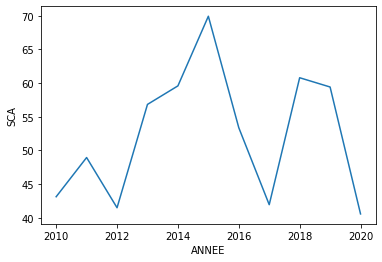

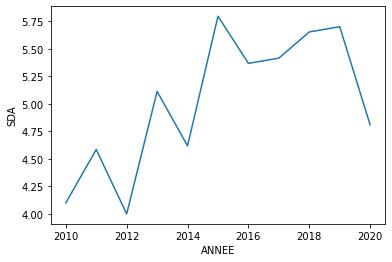

In [67]:
### On observe les courbes de SCA et SDA en fonction des années

print("COMMUNE = ",communeloc)
print()
blo = data.loc[data['COMMUNE'] == communeloc]
plt.plot(blo.ANNEE, blo.SCA)
plt.xlabel('ANNEE')
plt.ylabel('SCA')
plt.show()




blo = data.loc[data['COMMUNE'] == communeloc]
plt.plot(blo.ANNEE, blo.SDA)
plt.xlabel('ANNEE')
plt.ylabel('SDA')
plt.show()

In [68]:
## On procede a d'autre verification afin de savoir si les données ont du sens, par exemple si Tmax > Tmin tout le temps. 

tma =dfdf.TMAX.tolist()
tmi =dfdf.TMIN.tolist()
for i in range(len(tma)):
    if tma[i] < tmi[i]: 
        print("PROBLEME ICI","tmax", tma[i] ," tmin", tmi[i])

print('AUCUN PROBLEME')

AUCUN PROBLEME


## VISUALISATION <a class="anchor" id="#chapter5"></a>

Pour la suite on met en place different visualisation des données afin de prendre en main le dataset plus precisement et d'observer certain point utile par la suite. 

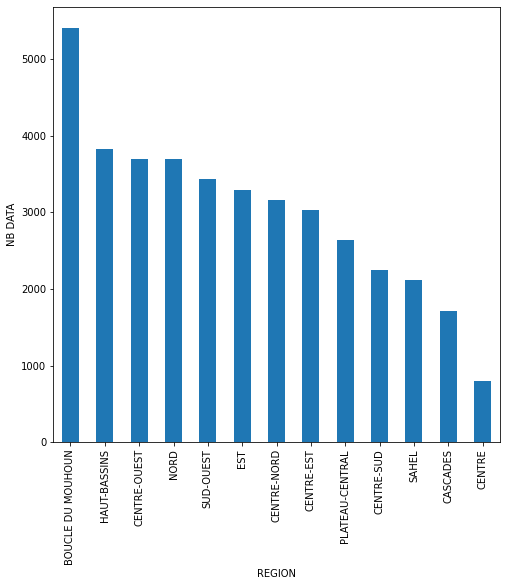

In [69]:
#### Histogramme du nombre de data par region
plt.figure(figsize=(8,8),edgecolor='blue')
result['REGION'].value_counts().plot(kind='bar')
plt.xlabel('REGION')
plt.ylabel('NB DATA')
plt.xticks(rotation='vertical')

plt.show()

In [70]:
## Matrice de corrélation entre les differentes regions

df_co_sca = pd.DataFrame()
df_co_sda = pd.DataFrame()

region = result['REGION'].unique().tolist()

for i in range(len(region)):
    reg = region[i]
    df_a = result[result['REGION'] == reg]
    
    df_a = df_a.groupby(['ANNEE']).mean()
    df_a.reset_index(level=0, inplace=True)
    df_co_sca[f"{region[i]}"] = df_a["SCA"]
    df_co_sda[f"{region[i]}"] = df_a["SDA"]

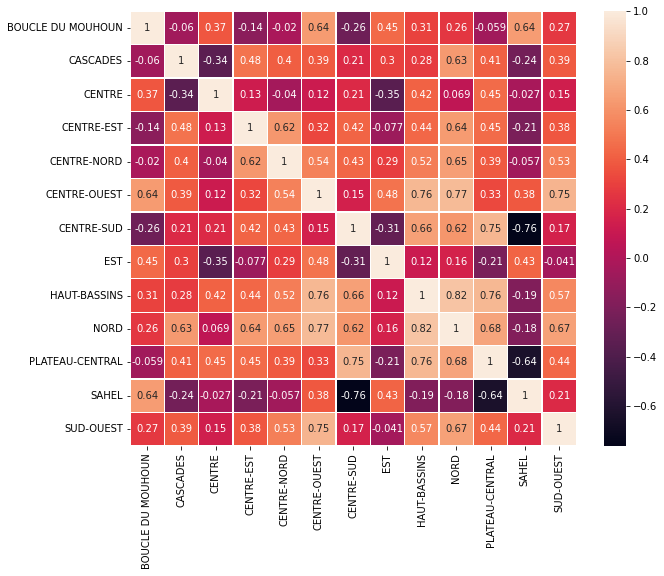

In [71]:
###SDA

corr_df = df_co_sda.corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, linewidths=.3)
plt.show()



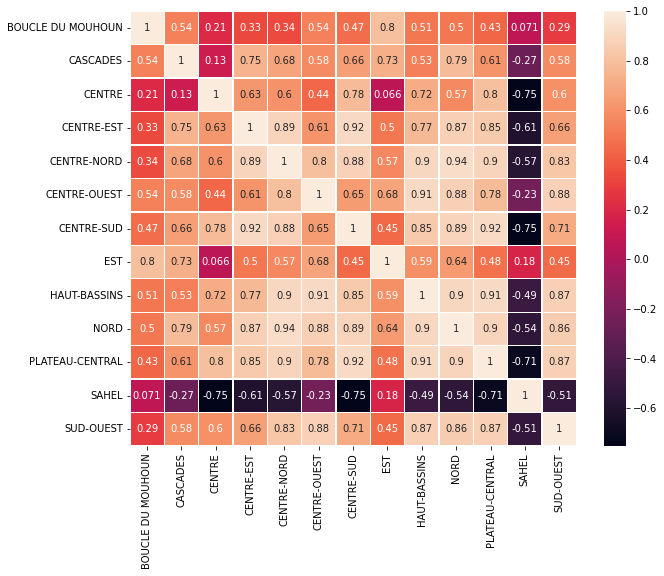

In [72]:
##SCA

corr_df = df_co_sca.corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, linewidths=.3)
plt.show()



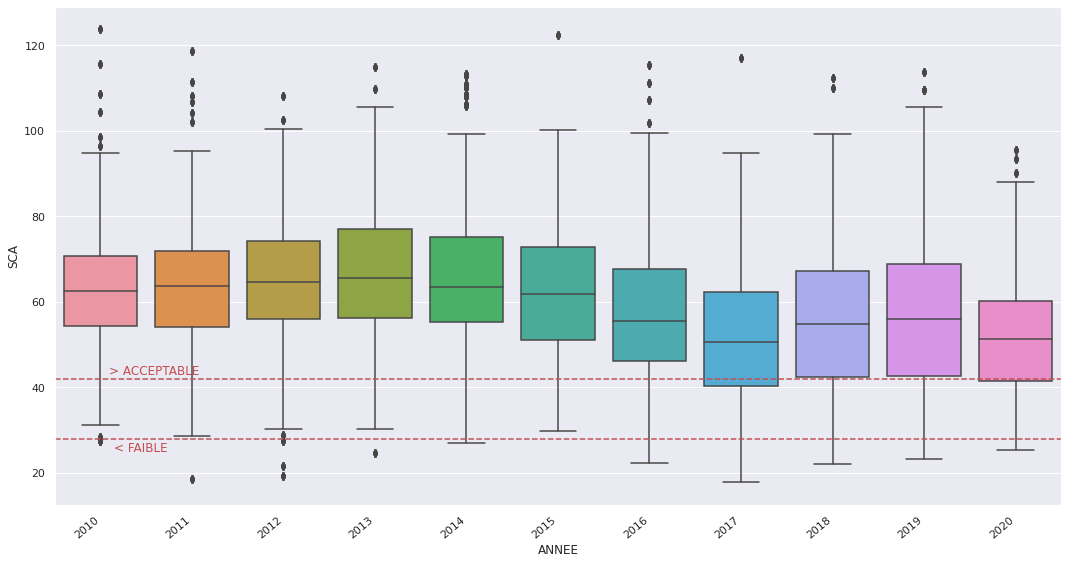

In [73]:
###Observation du SCA en fonction des années, les lignes rouges correspondent au score qui determine le risque par les 
##organismes (PAM ici) en categorie 

sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(15,8)})
ax = sns.boxplot(x = 'ANNEE', y = 'SCA', data = result)
ax.axhline(28, ls='--',color='r')
ax.axhline(42, ls='--',color='r')
ax.text(0.15,25, "< FAIBLE", color='r')
ax.text(0.09,43, "> ACCEPTABLE", color='r')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

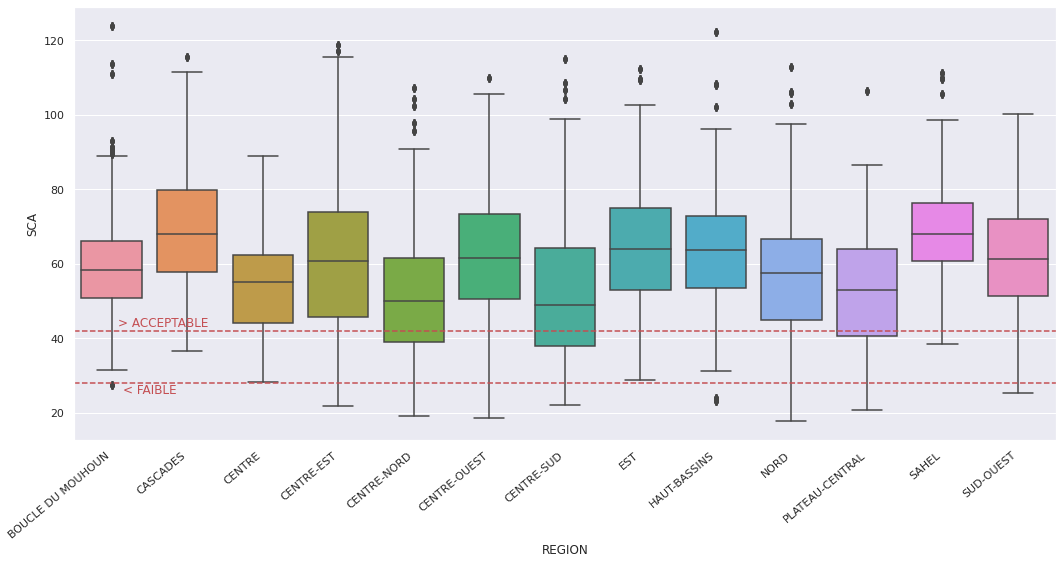

In [74]:
###Observation du SCA en fonction des region, les lignes rouges correspondent au score qui determine le risque par les 
##organismes (PAM ici) en categorie 

sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(15,8)})
ax = sns.boxplot(x = 'REGION', y = 'SCA', data = result)
ax.axhline(28, ls='--',color='r')
ax.axhline(42, ls='--',color='r')
ax.text(0.15,25, "< FAIBLE", color='r')
ax.text(0.09,43, "> ACCEPTABLE", color='r')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

L'année 2020 semble avoir un sca plus faible que les autres années. On va comparé 2020 et 2014 par region afin de voir si on peut observer quelque chose. 

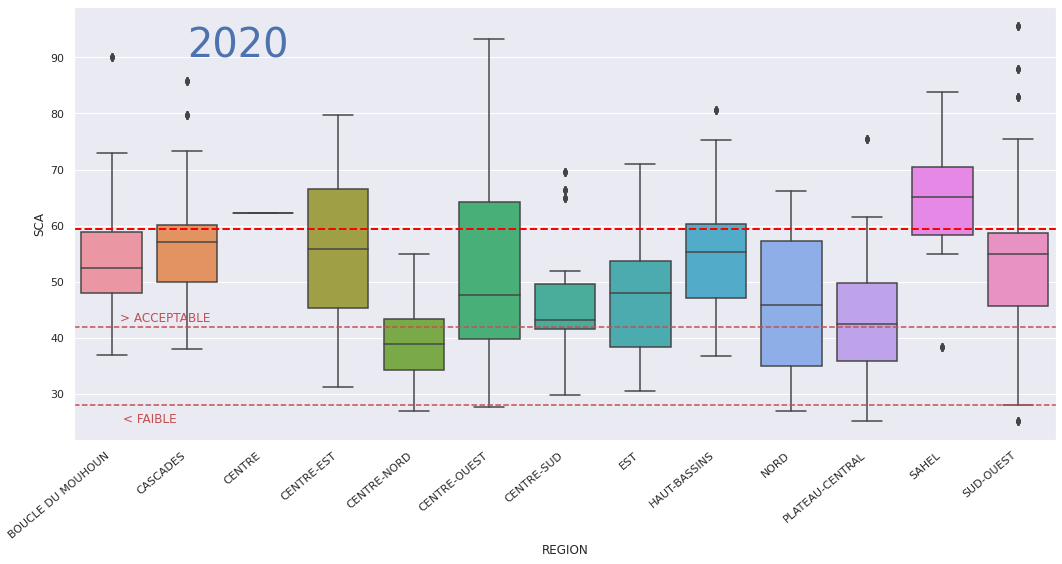

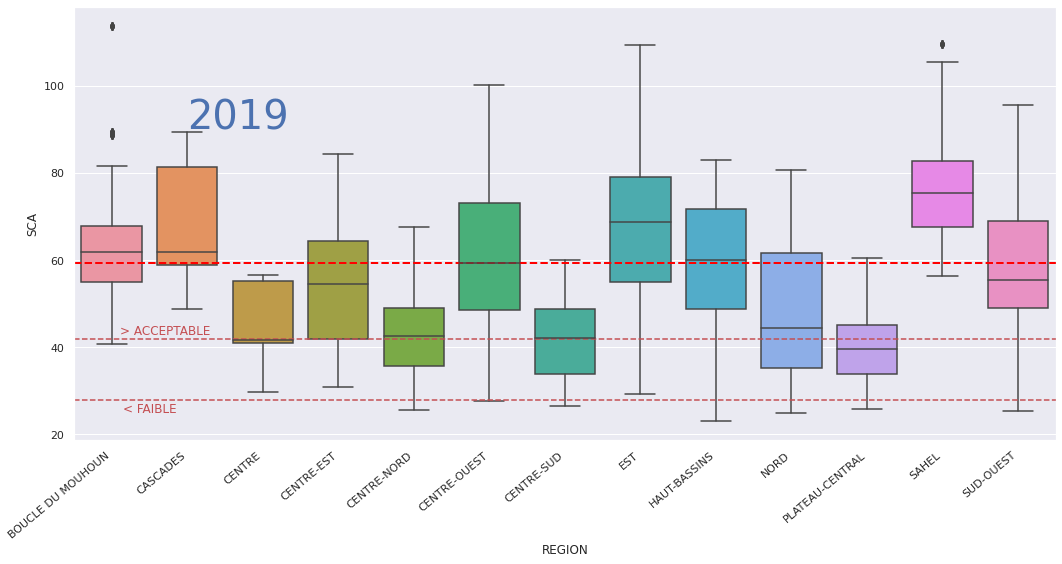

In [75]:
df_test = result.loc[result['ANNEE'] == 2020]

sns.set(rc={'figure.figsize':(15,8)})
ax = sns.boxplot(x = 'REGION', y = 'SCA', data = df_test)

ax.axhline(28, ls='--',color='r')
ax.axhline(42, ls='--',color='r')
ax.text(0.15,25, "< FAIBLE", color='r')
ax.axhline(59.45, ls='--',color='red',linewidth=2)
ax.text(0.11,43, "> ACCEPTABLE", color='r')
ax.text(1,90, "2020", color='b',fontsize=40)


ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()


df_test = result.loc[result['ANNEE'] == 2019]

sns.set(rc={'figure.figsize':(15,8)})
ax = sns.boxplot(x = 'REGION', y = 'SCA', data = df_test)

ax.axhline(28, ls='--',color='r')
ax.axhline(42, ls='--',color='r')
ax.text(0.15,25, "< FAIBLE", color='r')
ax.axhline(59.45, ls='--',color='red',linewidth=2)
ax.text(0.11,43, "> ACCEPTABLE", color='r')
ax.text(1,90, "2019", color='b',fontsize=40)


ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

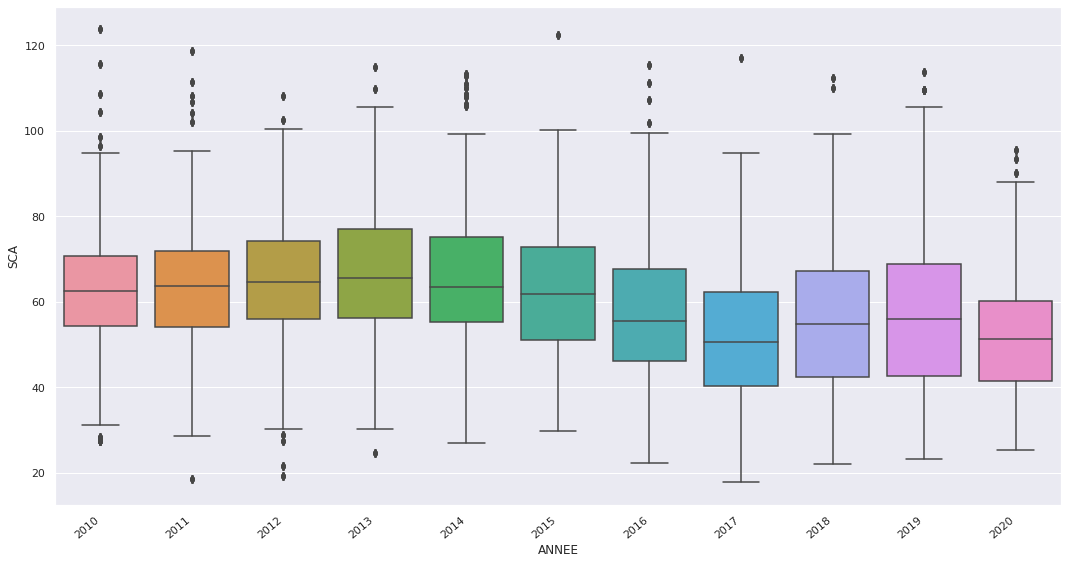

In [76]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(15,8)})
ax = sns.boxplot(x = 'ANNEE', y = 'SCA', data = result)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [77]:
observ = result.groupby(['ANNEE']).mean()
observ["PLUIE"]


ANNEE
2010    2.853506
2011    1.332055
2012    2.366041
2013    1.528531
2014    1.569945
2015    1.699512
2016    1.159556
2017    1.566389
2018    1.855977
2019    2.092466
2020    1.919924
Name: PLUIE, dtype: float64

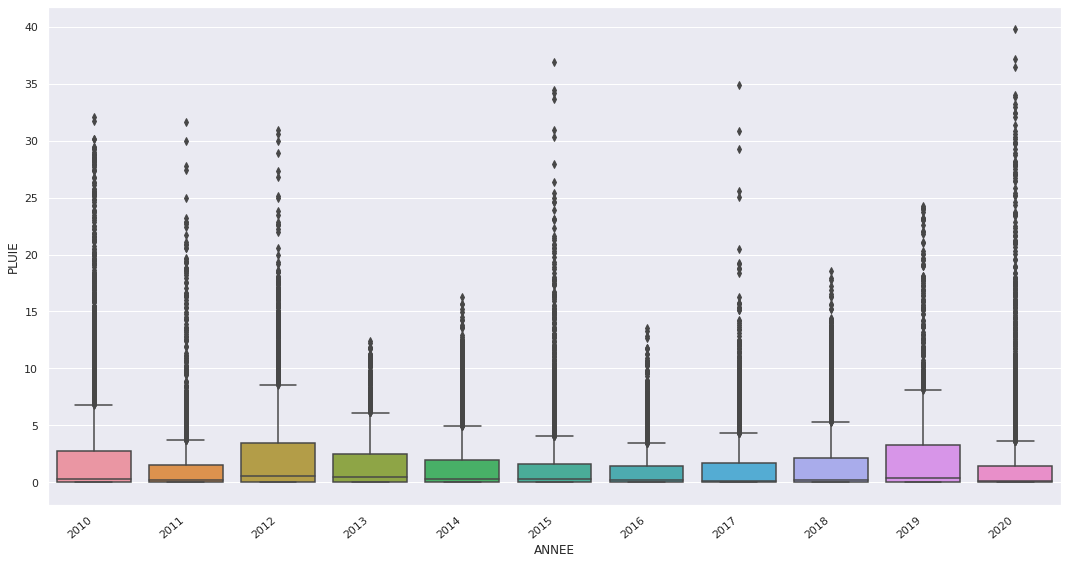

In [78]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(15,8)})
ax = sns.boxplot(x = 'ANNEE', y = 'PLUIE', data = result)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

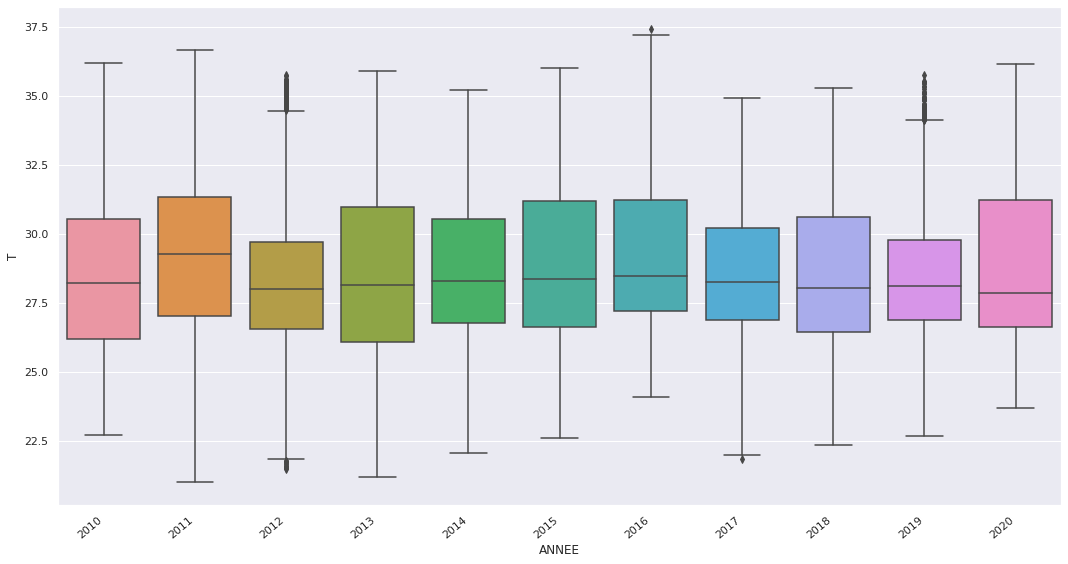

In [79]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(15,8)})
ax = sns.boxplot(x = 'ANNEE', y = 'T', data = result)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [80]:
dataset = result
dataset.shape

(39072, 20)

In [81]:
dataset

,REGION,PROVINCE,COMMUNE,ANNEE,MOIS,VHI,vci,T,TMAX,TMIN,PLUIE,EVAPO,LAIHV,LAILV,NDVI,TCI,SOILT,SCA,SDA,ADD_PRED
0,BOUCLE DU MOUHOUN,BALÉ,BAGASSI,2010,1,3.719003,7.219751,26.650786,29.560092,23.551974,1.137476,6.850287,1.491323,1.062442,0.246910,48.422912,27.324144,72.683333,5.947619,0.0
1,BOUCLE DU MOUHOUN,BALÉ,BAGASSI,2010,2,3.916808,6.473407,28.255425,31.075893,25.434207,1.253889,7.431982,1.500718,1.058801,0.238709,49.993359,29.203759,72.683333,5.947619,0.0
2,BOUCLE DU MOUHOUN,BALÉ,BAGASSI,2010,3,4.732832,5.841726,28.871812,31.417547,25.929400,1.549616,7.679938,1.526213,1.073386,0.227814,46.386054,31.483698,72.683333,5.947619,0.0
3,BOUCLE DU MOUHOUN,BALÉ,BAGASSI,2010,4,4.884418,4.383875,29.387051,31.863993,26.353118,1.937619,7.531034,1.573203,1.116193,0.254641,44.946432,33.100669,72.683333,5.947619,0.0
4,BOUCLE DU MOUHOUN,BALÉ,BAGASSI,2010,5,5.297632,4.404184,28.042482,30.144822,26.097969,3.851873,6.500372,1.610658,1.162001,0.295230,51.949996,33.816946,72.683333,5.947619,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39067,SUD-OUEST,PONI,PERIGBAN,2020,8,2.595101,1.451213,24.450618,26.893827,22.395061,10.106173,3.611111,1.411111,2.075309,0.596393,54.308430,27.325608,33.833333,2.880952,0.0
39068,SUD-OUEST,PONI,PERIGBAN,2020,9,3.284226,4.076337,25.430864,28.351852,21.274075,8.460495,5.476543,1.414815,2.262963,0.683028,41.269855,26.747224,33.833333,2.880952,0.0
39069,SUD-OUEST,PONI,PERIGBAN,2020,10,5.257229,6.433293,25.451851,27.902467,22.203703,11.551852,4.549383,1.414815,2.180247,0.624878,43.002583,27.163887,33.833333,2.880952,0.0
39070,SUD-OUEST,PONI,PERIGBAN,2020,11,3.735672,7.599057,27.545679,33.481482,20.603704,0.000000,8.360494,1.411111,1.817284,0.470741,46.093376,28.156785,33.833333,2.880952,0.0


In [82]:
## Verifie que chaque commune possede le bon nombre de row
listcom = dataset.COMMUNE.unique()
for i in range(len(listcom)):
    blo = dataset.loc[data['COMMUNE'] == listcom[i]]
    if len(blo) != 132 :
        print(listcom[i]," : " ,len(blo))
        
print("END")

END


## PREPROCESSING <a class="anchor" id="#chapter7"></a>

### Creation des classes <a class="anchor" id="#section_7_1"></a>

Nous parlerons ici seulement du cas de la classification, la regression ne sera donc pas detaillé. 

Pour commencer, il faut creer les classes. On prendra pour exemple le SCA, on observe donc la repartitions des SCA grace a un histogramme.

In [83]:
dataframe = dataset

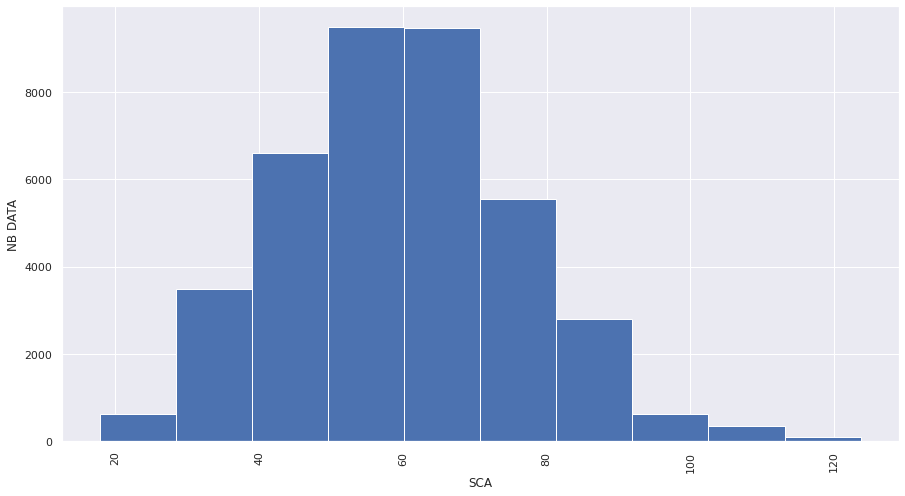

In [84]:
hist = dataframe['SCA'].hist()
plt.xlabel('SCA')
plt.ylabel('NB DATA')
plt.xticks(rotation='vertical')

plt.show()

On commence par une classification binaire afin d'obtenir des resultats de reference. 
On utilisera la mediane afin de determiner les deux classes. 

On definit les features ainsi que notre label qu'on cherchera a predire.

In [85]:
mediane = np.quantile(dataframe['SCA'],0.5)
print("La mediane du SCA est de : ",mediane)

mediane1 = np.quantile(dataframe['SDA'],0.5)
print("La mediane du SDA est de : ",mediane1)

La mediane du SCA est de :  59.45416666666667
La mediane du SDA est de :  4.985714285714286


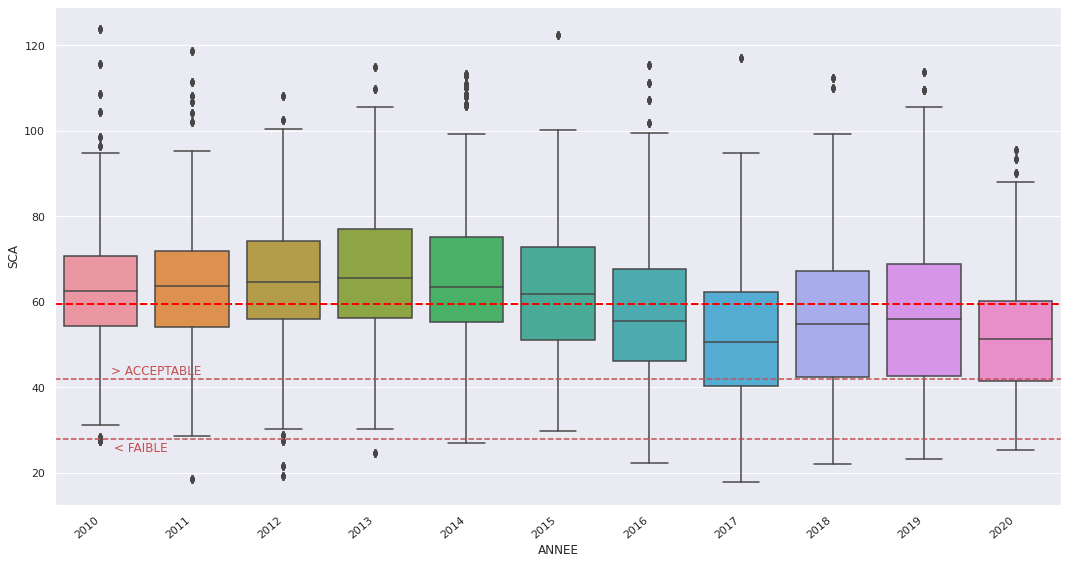

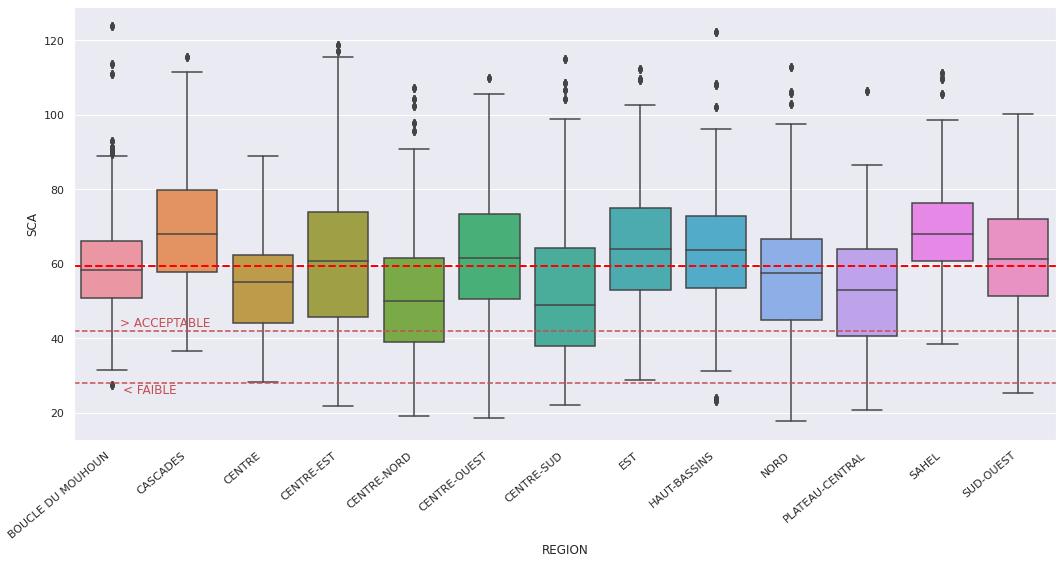

In [86]:
## On observe la mediane pour le sca par region puis par année

sns.set(rc={'figure.figsize':(15,8)})
ax = sns.boxplot(x = 'ANNEE', y = 'SCA', data = dataframe)

ax.axhline(28, ls='--',color='r')
ax.axhline(42, ls='--',color='r')
ax.axhline(mediane, ls='--',color='red',linewidth=2)
ax.text(0.15,25, "< FAIBLE", color='r')
ax.text(0.11,43, "> ACCEPTABLE", color='r')

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()


## On observe la mediane pour le sca par region puis par année

sns.set(rc={'figure.figsize':(15,8)})
ax = sns.boxplot(x = 'REGION', y = 'SCA', data = dataframe)

ax.axhline(28, ls='--',color='r')
ax.axhline(42, ls='--',color='r')
ax.axhline(59.45, ls='--',color='red',linewidth=2)
ax.text(0.15,25, "< FAIBLE", color='r')
ax.text(0.11,43, "> ACCEPTABLE", color='r')

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [87]:
### On parcours le dataset pour definir l'appartenance a la classe 0 ou 1 

dataframe['Class_SCA'] = 0

for i in range(len(dataframe)):
    if dataframe['SCA'][i] < mediane:
        dataframe['Class_SCA'][i] = 0
    if (dataframe['SCA'][i] >mediane):
        dataframe['Class_SCA'][i] = 1
        

dataframe['Class_SDA'] = 0

for i in range(len(dataframe)):
    if dataframe['SDA'][i] < mediane1:
        dataframe['Class_SDA'][i] = 0
    if (dataframe['SDA'][i] >mediane1):
        dataframe['Class_SDA'][i] = 1

/home/yonas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/yonas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/yonas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yonas/.local/lib/python3.6/site-packages/i

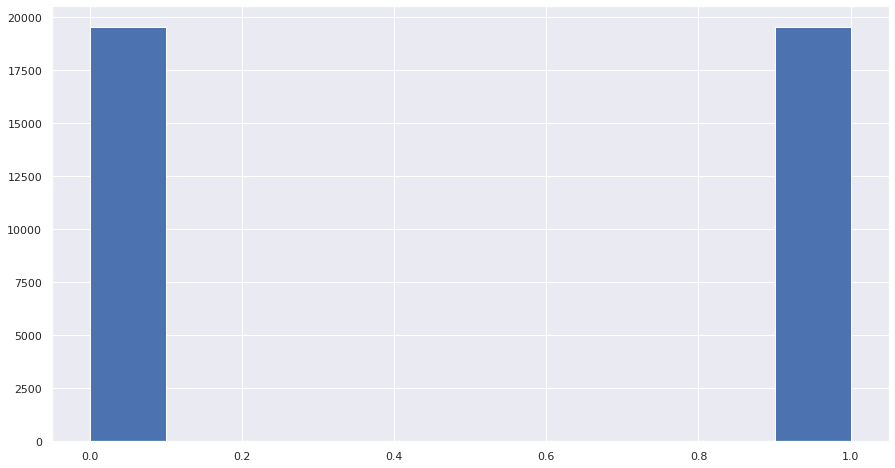

In [88]:
### On observe la repartition des classes ( ici elles sont logiquement egale )
hist = dataframe['Class_SCA'].hist()

Pour finir , afin de preparer le dataset pour les modeles on transforme les donnée Spatial ( REGION , PROVINCES et COMMUNES ) en label pour le modele. 

In [89]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(dataframe['REGION'])
dataframe['REGION_label'] = le.transform(dataframe['REGION'])
le.fit(dataset['PROVINCE'])
dataframe['PROVINCE_label'] = le.transform(dataframe['PROVINCE'])
le.fit(dataset['COMMUNE'])
dataframe['COMMUNE_label'] = le.transform(dataframe['COMMUNE'])

In [200]:
##Defini nos features et nos label pour la sutie

data_features = dataframe
data_features =  data_features.drop('REGION', 1)
data_features =  data_features.drop('COMMUNE', 1)
data_features =  data_features.drop('PROVINCE', 1)
data_features =  data_features.drop('SCA', 1)
data_features =  data_features.drop('SDA', 1)
data_features =  data_features.drop('Class_SCA', 1)
data_features =  data_features.drop('Class_SDA', 1)
data_features =  data_features.drop('ADD_PRED', 1)

data_label = 'Class_SDA'

data_features = data_features.columns
data_features

Index(['ANNEE', 'MOIS', 'VHI', 'vci', 'T', 'TMAX', 'TMIN', 'PLUIE', 'EVAPO',
       'LAIHV', 'LAILV', 'NDVI', 'TCI', 'SOILT', 'REGION_label',
       'PROVINCE_label', 'COMMUNE_label'],
      dtype='object')

## Features selection <a class="anchor" id="#chapter6"></a>

Afin de selectionner les features que nous allons utiliser par la suite pour notre modele, nous pouvons observer la matrice de correlation. Une autre methode est les "variance inflation factor" qui permet de detecter la multicolinéarité entre les features. 

### Matrice de corrélation <a class="anchor" id="#section_6_1"></a>

<AxesSubplot:>

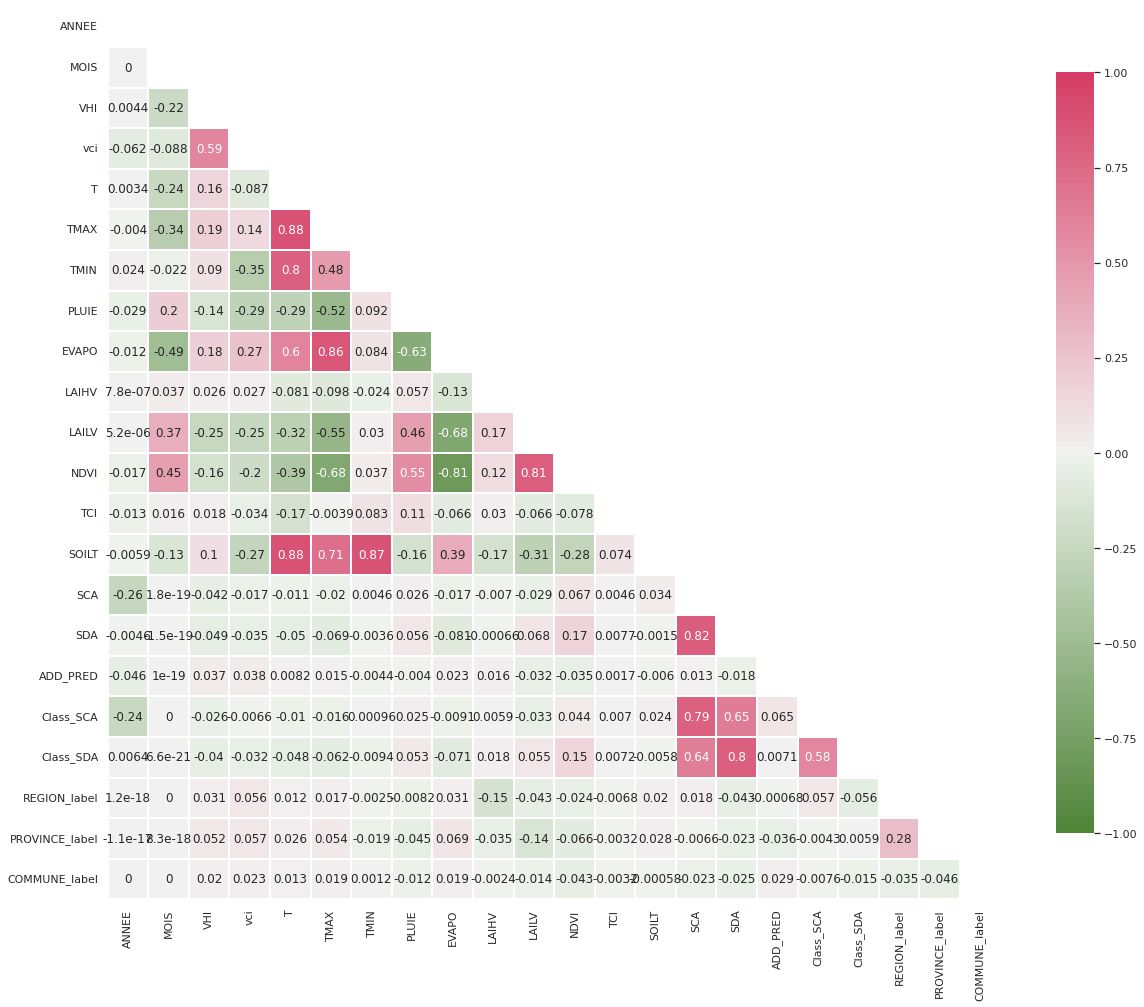

In [91]:
import matplotlib.pyplot as plt


sns.set_theme(style="white")

# Compute the correlation matrix
corr = dataset.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(120, 2, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,vmin=-1, vmax=1, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .7},annot=True)

### VIF <a class="anchor" id="#section_6_2"></a>

In [92]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [93]:
###Pour calculer le VIF il faut conserver les données numerique seulement donc on drop les données spatial
## On se concentre sur le SDA pour cette exemple 
## On drop aussi les données temporelle dans ce cas afin d'observer les features seulement

dataset_sca_vif =  dataset.drop('REGION', 1)
dataset_sca_vif =  dataset_sca_vif.drop('COMMUNE', 1)
dataset_sca_vif =  dataset_sca_vif.drop('PROVINCE', 1)
dataset_sca_vif =  dataset_sca_vif.drop('SCA', 1)
dataset_sca_vif =  dataset_sca_vif.drop('SDA', 1)

dataset_sca_vif =  dataset_sca_vif.drop('Class_SDA', 1)
dataset_sca_vif =  dataset_sca_vif.drop('ADD_PRED', 1)
dataset_sca_vif =  dataset_sca_vif.drop('ANNEE', 1)
dataset_sca_vif =  dataset_sca_vif.drop('MOIS', 1)
dataset_sca_vif =  dataset_sca_vif.drop('Class_SCA', 1)

In [94]:
data_vif = calc_vif(dataset_sca_vif)

In [95]:
## Ici le seuil est tres elevé afin d'osberver les resultat du dataset de base sans drop de features. 
## Plus le VIF d'une features est proche de 1 moins la features est corrélé avec les autres 
while data_vif["VIF"].max() > 10000000000000:
    data_vif = calc_vif(dataset_sca_vif)
    dataset_sca_vif = dataset_sca_vif.drop(data_vif["variables"][data_vif["VIF"].idxmax()], 1)
    

print("vif final =")
data_vif


vif final =


,variables,VIF
0,VHI,38.941880
1,vci,39.420977
2,T,16164.246096
3,TMAX,8499.549359
4,TMIN,1866.549497
5,PLUIE,2.548907
6,EVAPO,222.385176
7,LAIHV,5.129926
8,LAILV,109.307154
9,NDVI,39.876142


### Principal Component Analysis (PCA)

In [208]:
data_features

Index(['ANNEE', 'MOIS', 'VHI', 'vci', 'T', 'TMAX', 'TMIN', 'PLUIE', 'EVAPO',
       'LAIHV', 'LAILV', 'NDVI', 'TCI', 'SOILT', 'REGION_label',
       'PROVINCE_label', 'COMMUNE_label'],
      dtype='object')

In [209]:
from sklearn.model_selection import train_test_split


# Separate features and labels
data_X, data_y = dataframe[data_features].values, dataframe[data_label].values



In [211]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(data_X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])

finalDf = pd.concat([principalDf, dataframe[['Class_SCA','REGION',"ANNEE"]]], axis = 1)

In [212]:
finalDf

,principal component 1,principal component 2,principal component 3,Class_SCA,REGION,ANNEE
0,-143.341654,22.673384,0.285474,1,BOUCLE DU MOUHOUN,2010
1,-143.340180,22.634927,0.482346,1,BOUCLE DU MOUHOUN,2010
2,-143.338979,22.606217,-3.024071,1,BOUCLE DU MOUHOUN,2010
3,-143.338942,22.601191,-4.478724,1,BOUCLE DU MOUHOUN,2010
4,-143.343695,22.691510,3.018014,1,BOUCLE DU MOUHOUN,2010
...,...,...,...,...,...,...
39067,60.401613,-10.424864,10.883415,0,SUD-OUEST,2020
39068,60.408852,-10.556027,-1.357074,0,SUD-OUEST,2020
39069,60.407736,-10.513555,1.026023,0,SUD-OUEST,2020
39070,60.419661,-10.844565,-1.486623,0,SUD-OUEST,2020


In [213]:
pca.explained_variance_ratio_

array([0.96183372, 0.02202232, 0.00461585])

In [218]:
print(pca.singular_values_)

[16890.51525453  2555.7856917   1170.08908054]


### Random Forest Importance 

In [101]:
data_features_rfimportance = data_features



data_features_rfimportance =  data_features_rfimportance.drop('ANNEE', 1)
data_features_rfimportance =  data_features_rfimportance.drop('MOIS', 1)
data_features_rfimportance

Index(['VHI', 'vci', 'T', 'TMAX', 'TMIN', 'PLUIE', 'EVAPO', 'LAIHV', 'LAILV',
       'NDVI', 'TCI', 'SOILT', 'REGION_label', 'PROVINCE_label',
       'COMMUNE_label'],
      dtype='object')

In [102]:
### Selection random

from sklearn.model_selection import train_test_split




###Shuffle
dataframe_shuffle = dataframe
dataframe_shuffle = dataframe_shuffle.sample(frac=1).reset_index(drop=True)

# Separate features and labels
data_X, data_y = dataframe[data_features_rfimportance].values, dataframe[data_label].values

# Split data 75%-25% into training set and test set
x_train, x_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.25,
                                                                     random_state=100,
                                                                     stratify=data_y)

print ('Training Set: %d, Test Set: %d \n' % (y_train.size, y_test.size))

Training Set: 29304, Test Set: 9768 



In [103]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(x_train, y_train)

#recuperer importance des features
importances = clf.feature_importances_

#create dataframe for vizualisation

final_df = pd.DataFrame({"Features": pd.DataFrame(data_X).columns, "Importances":importances})
final_df = final_df.sort_values("Importances")


In [104]:
aa = dataframe[data_features_rfimportance].columns.tolist()
final_df = final_df.reset_index()

final_df =  final_df.drop('index', 1)

for i in range(len(final_df)):
    final_df["Features"][i] = aa[final_df["Features"][i]]



/home/yonas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/yonas/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [105]:

final_df

,Features,Importances
0,REGION_label,0.044863
1,PLUIE,0.047287
2,LAILV,0.060981
3,T,0.063574
4,SOILT,0.065366
5,TMAX,0.065661
6,TMIN,0.066098
7,EVAPO,0.067710
8,vci,0.068449
9,TCI,0.069098


In [106]:
final_df.Importances.sum()

1.0

In [107]:
#dataset.to_csv("dataset_SCA_SDA.csv", index=False)

### Train test split <a class="anchor" id="#section_7_2"></a>

Plusieurs methodes sont possible, ici on definiera notre test sur une REGION précise pour l'exemple, et notre train sur le reste des données. 
Une version 

In [108]:
## Selection par region

###dataTra =  dataframe[dataframe['REGION'] != "PLATEAU-CENTRAL"]
###dataTest = dataframe[dataframe['REGION'] == "PLATEAU-CENTRAL"]

### Pour selection par année 

###dataTra =  dataframe[dataframe['ANNEE'] != 2018]
###dataTest = dataframe[dataframe['ANNEE'] == 2018]

###_train, y_train = dataTra[data_features].values, dataTra[data_label].values
###x_test , y_test = dataTest[data_features].values, dataTest[data_label].values

###print ('Training Set: %d, Test Set: %d \n' % (y_train.size, y_test.size))

### Selection random

from sklearn.model_selection import train_test_split

###Shuffle
dataframe_shuffle = dataframe
dataframe_shuffle = dataframe_shuffle.sample(frac=1).reset_index(drop=True)

# Separate features and labels
data_X, data_y = dataframe[data_features].values, dataframe[data_label].values

# Split data 75%-25% into training set and test set
x_train, x_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.25,
                                                                     random_state=100,
                                                                     stratify=data_y)

print ('Training Set: %d, Test Set: %d \n' % (y_train.size, y_test.size))

Training Set: 29304, Test Set: 9768 



Text(0, 0.5, 'nombres')

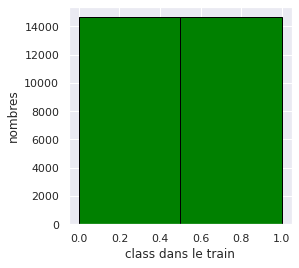

In [109]:
# On observe la repartiton des classe dans le train et dans le test 

sns.set(rc={'figure.figsize':(4,4)})

plt.hist(y_train, range = (0, 1), bins =2, color = 'green',
            edgecolor = 'black')
plt.xlabel('class dans le train')
plt.ylabel('nombres')




Text(0, 0.5, 'nombres')

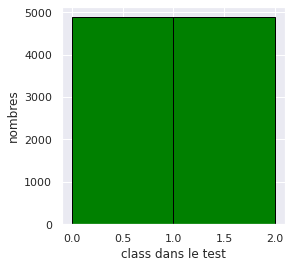

In [110]:
plt.hist(y_test, range = (0, 2), bins =2, color = 'green',
            edgecolor = 'black')
plt.xlabel('class dans le test')
plt.ylabel('nombres')

## Modeles MACHINE LEARNING <a class="anchor" id="#chapter8"></a>

Pour la suite on comparera different modele de machine learning afin de selectionner celui qui nous offre les meilleurs resultats.

In [111]:
from sklearn. metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score

### Les metriques sont ACCURACY , PRECISON et le RECALL


### LOGISTIC REGRESSION <a class="anchor" id="#section_8_1"></a>

In [112]:
from sklearn.linear_model import LogisticRegression

# Set regularization rate
reg = 0.1

# train a logistic regression model on the training set
multi_model = LogisticRegression(max_iter=10000).fit(x_train, y_train)
print (multi_model)

LogisticRegression(max_iter=10000)


In [113]:
y_predictions = multi_model.predict(x_test)
print('Predicted labels: ', y_predictions[:35])
print('Actual labels   : ' ,y_test[:35])

Predicted labels:  [0 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1]
Actual labels   :  [1 0 0 1 1 0 0 0 1 0 1 0 1 0 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0 1 0 1 1 1]


In [114]:
print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

           0       0.56      0.56      0.56      4884
           1       0.56      0.55      0.55      4884

    accuracy                           0.56      9768
   macro avg       0.56      0.56      0.56      9768
weighted avg       0.56      0.56      0.56      9768



In [115]:
accura = accuracy_score(y_test, y_predictions)
preci =precision_score(y_test, y_predictions, average='macro')
recall =recall_score(y_test, y_predictions, average='macro')
print("Overall Accuracy:", "{:.2f}".format(accura))
print("Overall Precision:","{:.2f}".format(preci))
print("Overall Recall:","{:.2f}".format(recall))

Overall Accuracy: 0.56
Overall Precision: 0.56
Overall Recall: 0.56


In [116]:
# Print the confusion matrix
from sklearn.metrics import confusion_matrix

mcm = confusion_matrix(y_test, y_predictions)
print(mcm)

[[2733 2151]
 [2187 2697]]


### KNN  <a class="anchor" id="#section_8_2"></a>

In [117]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier()
neigh.fit(x_train, y_train)


KNeighborsClassifier()

In [118]:
y_predictions = neigh.predict(x_test)
print('Predicted labels: ', y_predictions[:35])
print('Actual labels   : ' ,y_test[:35])

Predicted labels:  [1 0 0 1 1 1 0 0 1 0 0 0 1 0 1 0 1 0 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1]
Actual labels   :  [1 0 0 1 1 0 0 0 1 0 1 0 1 0 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0 1 0 1 1 1]


In [119]:
print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      4884
           1       0.74      0.74      0.74      4884

    accuracy                           0.74      9768
   macro avg       0.74      0.74      0.74      9768
weighted avg       0.74      0.74      0.74      9768



In [120]:
accura = accuracy_score(y_test, y_predictions)
preci =precision_score(y_test, y_predictions, average='macro')
recall =recall_score(y_test, y_predictions, average='macro')
print("Overall Accuracy:", "{:.2f}".format(accura))
print("Overall Precision:","{:.2f}".format(preci))
print("Overall Recall:","{:.2f}".format(recall))

Overall Accuracy: 0.74
Overall Precision: 0.74
Overall Recall: 0.74


In [121]:
mcm = confusion_matrix(y_test, y_predictions)
print(mcm)

[[3614 1270]
 [1252 3632]]


### DECISION TREE <a class="anchor" id="#section_8_3"></a>

In [122]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=100)
clf.fit(x_train, y_train)

DecisionTreeClassifier(random_state=100)

In [123]:
y_predictions = clf.predict(x_test)
print('Predicted labels: ', y_predictions[:35])
print('Actual labels   : ' ,y_test[:35])

Predicted labels:  [1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0 1 0 1 1 1]
Actual labels   :  [1 0 0 1 1 0 0 0 1 0 1 0 1 0 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0 1 0 1 1 1]


In [124]:
print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      4884
           1       0.93      0.93      0.93      4884

    accuracy                           0.93      9768
   macro avg       0.93      0.93      0.93      9768
weighted avg       0.93      0.93      0.93      9768



In [125]:
accura = accuracy_score(y_test, y_predictions)
preci =precision_score(y_test, y_predictions, average='macro')
recall =recall_score(y_test, y_predictions, average='macro')
print("Overall Accuracy:", "{:.2f}".format(accura))
print("Overall Precision:","{:.2f}".format(preci))
print("Overall Recall:","{:.2f}".format(recall))

Overall Accuracy: 0.93
Overall Precision: 0.93
Overall Recall: 0.93


In [126]:
mcm = confusion_matrix(y_test, y_predictions)
print(mcm)

[[4533  351]
 [ 330 4554]]


### RANDOM FOREST CLASSIFIER <a class="anchor" id="#section_8_4"></a>

In [127]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(x_train, y_train)

RandomForestClassifier()

In [128]:
y_predictions = clf.predict(x_test)
print('Predicted labels: ', y_predictions[:35])
print('Actual labels   : ' ,y_test[:35])

Predicted labels:  [1 0 0 1 1 1 0 0 1 1 1 0 1 0 1 1 1 0 1 0 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1]
Actual labels   :  [1 0 0 1 1 0 0 0 1 0 1 0 1 0 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0 1 0 1 1 1]


In [129]:
print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      4884
           1       0.84      0.85      0.84      4884

    accuracy                           0.84      9768
   macro avg       0.84      0.84      0.84      9768
weighted avg       0.84      0.84      0.84      9768



In [130]:
accura = accuracy_score(y_test, y_predictions)
preci =precision_score(y_test, y_predictions, average='macro')
recall =recall_score(y_test, y_predictions, average='macro')
print("Overall Accuracy:", "{:.2f}".format(accura))
print("Overall Precision:","{:.2f}".format(preci))
print("Overall Recall:","{:.2f}".format(recall))

Overall Accuracy: 0.84
Overall Precision: 0.84
Overall Recall: 0.84


In [131]:
mcm = confusion_matrix(y_test, y_predictions)
print(mcm)

[[4078  806]
 [ 722 4162]]


### GRADIENT BOOSTING CLASSIFIER <a class="anchor" id="#section_8_5"></a>

In [132]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()
clf.fit(x_train, y_train)

GradientBoostingClassifier()

In [133]:
y_predictions = clf.predict(x_test)
print('Predicted labels: ', y_predictions[:35])
print('Actual labels   : ' ,y_test[:35])

Predicted labels:  [1 0 0 1 0 1 0 0 1 1 1 0 1 0 1 0 1 0 0 0 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1]
Actual labels   :  [1 0 0 1 1 0 0 0 1 0 1 0 1 0 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0 1 0 1 1 1]


In [134]:
print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

           0       0.76      0.73      0.74      4884
           1       0.74      0.77      0.75      4884

    accuracy                           0.75      9768
   macro avg       0.75      0.75      0.75      9768
weighted avg       0.75      0.75      0.75      9768



In [135]:
accura = accuracy_score(y_test, y_predictions)
preci =precision_score(y_test, y_predictions, average='macro')
recall =recall_score(y_test, y_predictions, average='macro')
print("Overall Accuracy:", "{:.2f}".format(accura))
print("Overall Precision:","{:.2f}".format(preci))
print("Overall Recall:","{:.2f}".format(recall))

print(accura)
print(preci)
print(recall)


Overall Accuracy: 0.75
Overall Precision: 0.75
Overall Recall: 0.75
0.747031122031122
0.7473937996145599
0.7470311220311221


In [136]:
mcm = confusion_matrix(y_test, y_predictions)
print(mcm)

[[3555 1329]
 [1142 3742]]


## Prediction <a class="anchor" id="#chapter9"></a>

### TEMPOREL

### Année en fonction d'années <a class="anchor" id="#section_9_1"></a>

Maintenant que la classification a été mise en place, nous allons aller plus loin en essayant de prédire les années en fonction des années precedente. L'idée est de pouvoir prédire une année dans le cas ou l'enquete n'est pas realisable. 

De plus, la methode tournera 5 fois afin d'obtenir une moyenne et un ecart type. 

La methode selectionné est le random forest classifier.

In [137]:
##Liste des années
nom_region = dataframe.ANNEE.unique().tolist()
df_result = pd.DataFrame(columns=['REGION','Methode','Accuracy','Precision','Recall'])
dataTra = dataframe[dataframe['ANNEE'] == nom_region[0]]
dataTra

,REGION,PROVINCE,COMMUNE,ANNEE,MOIS,VHI,vci,T,TMAX,TMIN,...,TCI,SOILT,SCA,SDA,ADD_PRED,Class_SCA,Class_SDA,REGION_label,PROVINCE_label,COMMUNE_label
0,BOUCLE DU MOUHOUN,BALÉ,BAGASSI,2010,1,3.719003,7.219751,26.650786,29.560092,23.551974,...,48.422912,27.324144,72.683333,5.947619,0.0,1,1,0,0,4
1,BOUCLE DU MOUHOUN,BALÉ,BAGASSI,2010,2,3.916808,6.473407,28.255425,31.075893,25.434207,...,49.993359,29.203759,72.683333,5.947619,0.0,1,1,0,0,4
2,BOUCLE DU MOUHOUN,BALÉ,BAGASSI,2010,3,4.732832,5.841726,28.871812,31.417547,25.929400,...,46.386054,31.483698,72.683333,5.947619,0.0,1,1,0,0,4
3,BOUCLE DU MOUHOUN,BALÉ,BAGASSI,2010,4,4.884418,4.383875,29.387051,31.863993,26.353118,...,44.946432,33.100669,72.683333,5.947619,0.0,1,1,0,0,4
4,BOUCLE DU MOUHOUN,BALÉ,BAGASSI,2010,5,5.297632,4.404184,28.042482,30.144822,26.097969,...,51.949996,33.816946,72.683333,5.947619,0.0,1,1,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38947,SUD-OUEST,PONI,PERIGBAN,2010,8,3.608076,3.186478,24.196296,27.924693,21.901236,...,61.897954,27.249062,56.350000,4.514286,0.0,0,0,12,31,208
38948,SUD-OUEST,PONI,PERIGBAN,2010,9,3.298074,3.463199,25.225926,28.517283,21.256790,...,45.332422,26.945064,56.350000,4.514286,0.0,0,0,12,31,208
38949,SUD-OUEST,PONI,PERIGBAN,2010,10,6.239018,7.469890,26.053089,29.664198,22.118518,...,47.856648,27.530249,56.350000,4.514286,0.0,0,0,12,31,208
38950,SUD-OUEST,PONI,PERIGBAN,2010,11,5.262233,7.992902,28.271605,32.683951,21.845680,...,40.710796,28.294130,56.350000,4.514286,0.0,0,0,12,31,208


In [138]:

##Liste des années
nom_region = dataframe.ANNEE.unique().tolist()
df_result = pd.DataFrame(columns=['REGION','Methode','Accuracy','Precision','Recall'])
dataTra = dataframe[dataframe['ANNEE'] == nom_region[0]]
dataTra_add = pd.DataFrame()

### Creation Train test en fonction des années
for j in range (1,len(nom_region)):
    
    print("#############################################",j,"/",len(nom_region)-1)
    if j != 1:
        dataTra_add =  dataframe[dataframe['ANNEE'] == nom_region[j-1]]
    
    dataTest = dataframe[dataframe['ANNEE'] == nom_region[j]]
    dataTra = pd.concat([dataTra, dataTra_add])
    print("train :",dataTra.ANNEE.unique().tolist())
    print("test :",dataTest.ANNEE.unique().tolist())
    x_train, y_train = dataTra[data_features].values, dataTra[data_label].values
    x_test , y_test = dataTest[data_features].values, dataTest[data_label].values
    print(nom_region[j])
    print ('Training Set: %d, Test Set: %d \n' % (y_train.size, y_test.size))
    
### Classification ( x5 pour obtenir une moyenne avec ecart type)    
    for i in range(5):
       
        
        
###RANDOM CLASSIFIER

        clf = RandomForestClassifier()
        clf.fit(x_train, y_train)
        y_predictions = clf.predict(x_test)
        
        ###print(classification_report(y_test, y_predictions))
        accura = accuracy_score(y_test, y_predictions)
        preci =precision_score(y_test, y_predictions, average='macro')
        recall =recall_score(y_test, y_predictions, average='macro')
        ###print("Overall Accuracy:", "{:.2f}".format(accura))
        ###print("Overall Precision:","{:.2f}".format(preci))
        ###print("Overall Recall:","{:.2f}".format(recall))
        df_add= {'REGION' : nom_region[j], 
                'Methode' : "RandomClassif", 
                'Accuracy' : accura,
                'Precision' : preci,
                'Recall' : recall,
                }
        df_result = df_result.append(df_add, ignore_index = True)                                 

        
        ###print()
        mcm = confusion_matrix(y_test, y_predictions)
        ##print(mcm)
        ###print()

############################################# 1 / 10
train : [2010]
test : [2011]
2011
Training Set: 3552, Test Set: 3552 

############################################# 2 / 10
train : [2010, 2011]
test : [2012]
2012
Training Set: 7104, Test Set: 3552 

############################################# 3 / 10
train : [2010, 2011, 2012]
test : [2013]
2013
Training Set: 10656, Test Set: 3552 

############################################# 4 / 10
train : [2010, 2011, 2012, 2013]
test : [2014]
2014
Training Set: 14208, Test Set: 3552 



KeyboardInterrupt: 

In [ ]:
df_result1 = df_result.groupby("REGION").mean()
### print(df_result1.to_latex(index=False)) 


print(df_result1)


In [ ]:
duwu = df_result1.mean()
duwu

In [ ]:
# Draw a vertical boxplot grouped 
# by a categorical variable:


sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(15,8)})
ax = sns.boxplot(x = 'REGION', y = 'Accuracy', data = df_result)

ax.axhline(0.5, ls='--',color='r')



ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

### SPATIAL

Pour commencer, on cherche a faire la prediction d'une region en fonction de toutes les autres regions. 

In [185]:
nom_region = dataframe.REGION.unique().tolist()
df_result = pd.DataFrame(columns=['REGION','Methode','Accuracy','Precision','Recall'])


### Creation Train test en fonction des années
for j in range (0,len(nom_region)):
    
    ##Liste des nom de region
    
    dataTra = dataframe[dataframe['REGION'] != nom_region[j]]
    dataTest = dataframe[dataframe['REGION'] == nom_region[j]]
    print("train :",dataTra.REGION.unique().tolist())
    print("test :",dataTest.REGION.unique().tolist())
    x_train, y_train = dataTra[data_features].values, dataTra[data_label].values
    x_test , y_test = dataTest[data_features].values, dataTest[data_label].values
    
    print ('Training Set: %d, Test Set: %d \n' % (y_train.size, y_test.size))
    
### Classification ( x5 pour obtenir une moyenne avec ecart type)    
    for i in range(5):
       
        
        
###RANDOM CLASSIFIER

        clf = LogisticRegression(max_iter=10000).fit(x_train, y_train)
        #clf = KNeighborsClassifier()
        ##clf = RandomForestClassifier()
         ##clf = DecisionTreeClassifier()
        ##clf = GradientBoostingClassifier()
        clf.fit(x_train, y_train)
        y_predictions = clf.predict(x_test)
        
        ###print(classification_report(y_test, y_predictions))
        accura = accuracy_score(y_test, y_predictions)
        preci =precision_score(y_test, y_predictions, average='macro')
        recall =recall_score(y_test, y_predictions, average='macro')
        ###print("Overall Accuracy:", "{:.2f}".format(accura))
        ###print("Overall Precision:","{:.2f}".format(preci))
        ###print("Overall Recall:","{:.2f}".format(recall))
        df_add= {'REGION' : nom_region[j], 
                'Methode' : "RandomClassif", 
                'Accuracy' : accura,
                'Precision' : preci,
                'Recall' : recall,
                }
        df_result = df_result.append(df_add, ignore_index = True)                                 

        
        ###print()
        ###mcm = confusion_matrix(y_test, y_predictions)
        ###print(mcm)
        ###print()

train : ['CASCADES', 'CENTRE', 'CENTRE-EST', 'CENTRE-NORD', 'CENTRE-OUEST', 'CENTRE-SUD', 'EST', 'HAUT-BASSINS', 'NORD', 'PLATEAU-CENTRAL', 'SAHEL', 'SUD-OUEST']
test : ['BOUCLE DU MOUHOUN']
Training Set: 33660, Test Set: 5412 

train : ['BOUCLE DU MOUHOUN', 'CENTRE', 'CENTRE-EST', 'CENTRE-NORD', 'CENTRE-OUEST', 'CENTRE-SUD', 'EST', 'HAUT-BASSINS', 'NORD', 'PLATEAU-CENTRAL', 'SAHEL', 'SUD-OUEST']
test : ['CASCADES']
Training Set: 37356, Test Set: 1716 

train : ['BOUCLE DU MOUHOUN', 'CASCADES', 'CENTRE-EST', 'CENTRE-NORD', 'CENTRE-OUEST', 'CENTRE-SUD', 'EST', 'HAUT-BASSINS', 'NORD', 'PLATEAU-CENTRAL', 'SAHEL', 'SUD-OUEST']
test : ['CENTRE']
Training Set: 38280, Test Set: 792 

train : ['BOUCLE DU MOUHOUN', 'CASCADES', 'CENTRE', 'CENTRE-NORD', 'CENTRE-OUEST', 'CENTRE-SUD', 'EST', 'HAUT-BASSINS', 'NORD', 'PLATEAU-CENTRAL', 'SAHEL', 'SUD-OUEST']
test : ['CENTRE-EST']
Training Set: 36036, Test Set: 3036 

train : ['BOUCLE DU MOUHOUN', 'CASCADES', 'CENTRE', 'CENTRE-EST', 'CENTRE-OUEST', 'CE

In [186]:
df_result1 = df_result.groupby("REGION").mean()
print(df_result1)


                   Accuracy  Precision    Recall
REGION                                          
BOUCLE DU MOUHOUN  0.481892   0.504094  0.504414
CASCADES           0.767483   0.489564  0.486713
CENTRE             0.513889   0.485269  0.483902
CENTRE-EST         0.470026   0.467069  0.468185
CENTRE-NORD        0.490846   0.490157  0.479106
CENTRE-OUEST       0.573052   0.573143  0.575289
CENTRE-SUD         0.405526   0.495322  0.495676
EST                0.497879   0.513813  0.516773
HAUT-BASSINS       0.321839   0.495826  0.496846
NORD               0.515422   0.430877  0.464410
PLATEAU-CENTRAL    0.724621   0.485270  0.489489
SAHEL              0.445549   0.423158  0.494938
SUD-OUEST          0.420455   0.531052  0.524232


In [187]:
duwu = df_result1.mean()
duwu

Accuracy     0.509883
Precision    0.491124
Recall       0.498459
dtype: float64

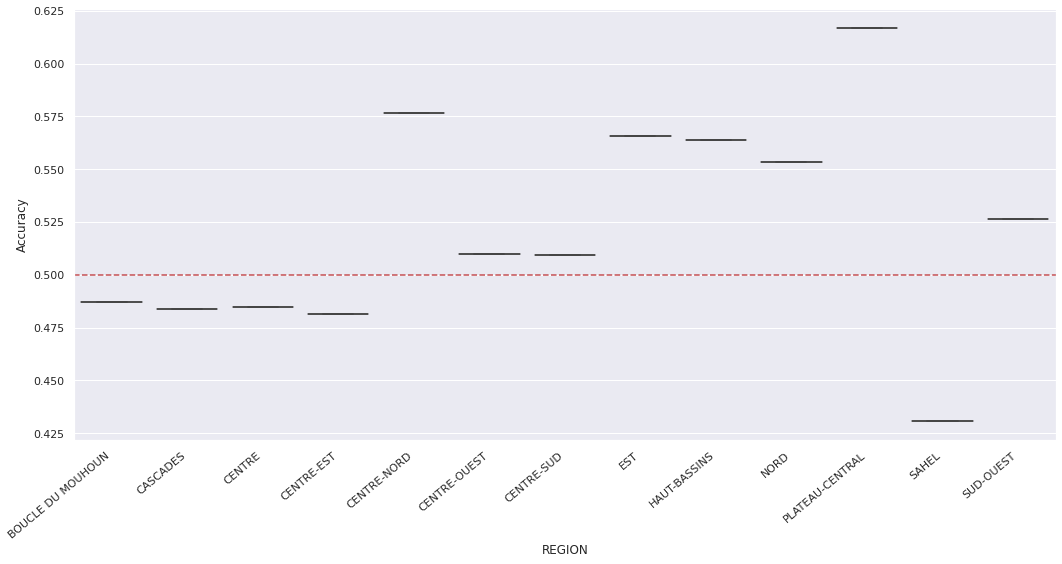

In [146]:
# Draw a vertical boxplot grouped 
# by a categorical variable:


sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(15,8)})
ax = sns.boxplot(x = 'REGION', y = 'Accuracy', data = df_result)

ax.axhline(0.5, ls='--',color='r')



ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

### Region en fonction des regions via corrélation <a class="anchor" id="#section_9_2"></a>

Pour cette partie, l'idée est de predire une region en particulier en fonction des autres regions. Le cas du burkina est particulier dans le sens ou les environnement sont tres different selon les regions. 
Par exemple la difference entre le nord et le sud au niveau de la vegetation. 

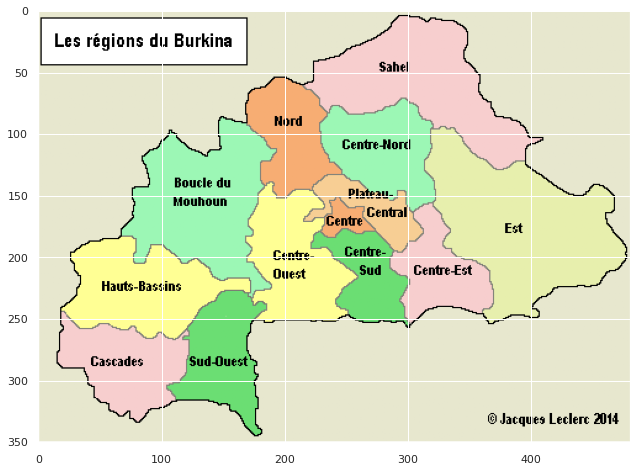

In [146]:
from matplotlib import image

img = image.imread("burkina region.PNG")
plt.imshow(img)
plt.show()

Pour le premier exemple, lors des test on se rend compte que la region "CENTRE-SUD" possede les resultats les moins élévés. 
Sur la matrice de corrélation entre les region on peut voir que les regions les plus corrélés a notre region a predire sont "CENTRE" , "CENTRE EST" , "CENTRE NORD" "PLATEAU CENTRAL" et "NORD". On utilisera donc ces regions en train. 

**POUR CHAQUE REGION**

Afin d'aller plus loin on va essayer de predire chaque region en fonction des 3 region les plus corrélé avec. 
Pour cela nous allons reprendre la matrice de corrélation entre les regions pour le SCA.

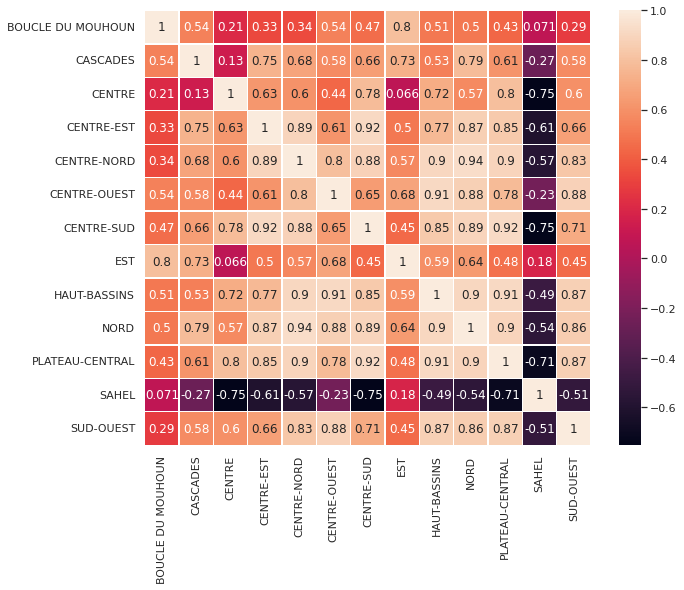

In [147]:
##SCA

corr_df = df_co_sca.corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, linewidths=.3)
plt.show()

In [148]:
### Comment on obtient les regions les plus corrélés
a = corr_df["CENTRE"].sort_values(ascending=False)
## Reset index pour obtenir le nom  de la region la plus corrélé 
a.reset_index()
a.index[1]

'PLATEAU-CENTRAL'

In [149]:
##Liste des années
nom_region = dataframe.REGION.unique().tolist()
df_result = pd.DataFrame(columns=['REGION','Methode','Accuracy','Precision','Recall'])



### Creation Train test en fonction des regions
for j in range (0,len(nom_region)):
    
    print("#############################################",j,"/",len(nom_region)-1)
    a = corr_df[nom_region[j]].sort_values(ascending=False)
    a.reset_index()
    dataTra = dataframe[dataframe['REGION'] == a.index[1]]
     ### On creer le train avec les 3 Region les plus corrélé
    for i in range(2,4):
        dataTra_add =  dataframe[dataframe['REGION'] == a.index[i]]
        dataTra = pd.concat([dataTra, dataTra_add])
    
    dataTest = dataframe[dataframe['REGION'] == nom_region[j]]
    print("train :",dataTra.REGION.unique().tolist())
    print("test :",dataTest.REGION.unique().tolist())
    x_train, y_train = dataTra[data_features].values, dataTra[data_label].values
    x_test , y_test = dataTest[data_features].values, dataTest[data_label].values
    print ('Training Set: %d, Test Set: %d \n' % (y_train.size, y_test.size))
    
### Classification ( x5 pour obtenir une moyenne avec ecart type)    
    for i in range(5):
       
        
        
###RANDOM CLASSIFIER

        clf = RandomForestClassifier()
        clf.fit(x_train, y_train)
        y_predictions = clf.predict(x_test)
        
        ###print(classification_report(y_test, y_predictions))
        accura = accuracy_score(y_test, y_predictions)
        preci =precision_score(y_test, y_predictions, average='macro')
        recall =recall_score(y_test, y_predictions, average='macro')
        ###print("Overall Accuracy:", "{:.2f}".format(accura))
        ###print("Overall Precision:","{:.2f}".format(preci))
        ###print("Overall Recall:","{:.2f}".format(recall))
        df_add= {'REGION' : nom_region[j], 
                'Methode' : "RandomClassif", 
                'Accuracy' : accura,
                'Precision' : preci,
                'Recall' : recall,
                }
        df_result = df_result.append(df_add, ignore_index = True)                                 

        
        ###print()
        mcm = confusion_matrix(y_test, y_predictions)
        ##print(mcm)
        ###print()

############################################# 0 / 12
train : ['EST', 'CASCADES', 'CENTRE-OUEST']
test : ['BOUCLE DU MOUHOUN']
Training Set: 8712, Test Set: 5412 

############################################# 1 / 12
train : ['NORD', 'CENTRE-EST', 'EST']
test : ['CASCADES']
Training Set: 10032, Test Set: 1716 

############################################# 2 / 12
train : ['PLATEAU-CENTRAL', 'CENTRE-SUD', 'HAUT-BASSINS']
test : ['CENTRE']
Training Set: 8712, Test Set: 792 

############################################# 3 / 12
train : ['CENTRE-SUD', 'CENTRE-NORD', 'NORD']
test : ['CENTRE-EST']
Training Set: 9108, Test Set: 3036 

############################################# 4 / 12
train : ['NORD', 'HAUT-BASSINS', 'PLATEAU-CENTRAL']
test : ['CENTRE-NORD']
Training Set: 10164, Test Set: 3168 

############################################# 5 / 12
train : ['HAUT-BASSINS', 'SUD-OUEST', 'NORD']
test : ['CENTRE-OUEST']
Training Set: 10956, Test Set: 3696 

######################################

In [150]:
df_result1 = df_result.groupby("REGION").mean()
df_result1

,Accuracy,Precision,Recall
REGION,,,
BOUCLE DU MOUHOUN,0.525905,0.575935,0.558647
CASCADES,0.593240,0.614081,0.638048
CENTRE,0.601263,0.585467,0.581885
CENTRE-EST,0.509354,0.538840,0.527601
CENTRE-NORD,0.588068,0.655153,0.675889
CENTRE-OUEST,0.575325,0.557920,0.549729
CENTRE-SUD,0.590374,0.591969,0.610593
EST,0.572788,0.563974,0.564403
HAUT-BASSINS,0.540857,0.561305,0.561136


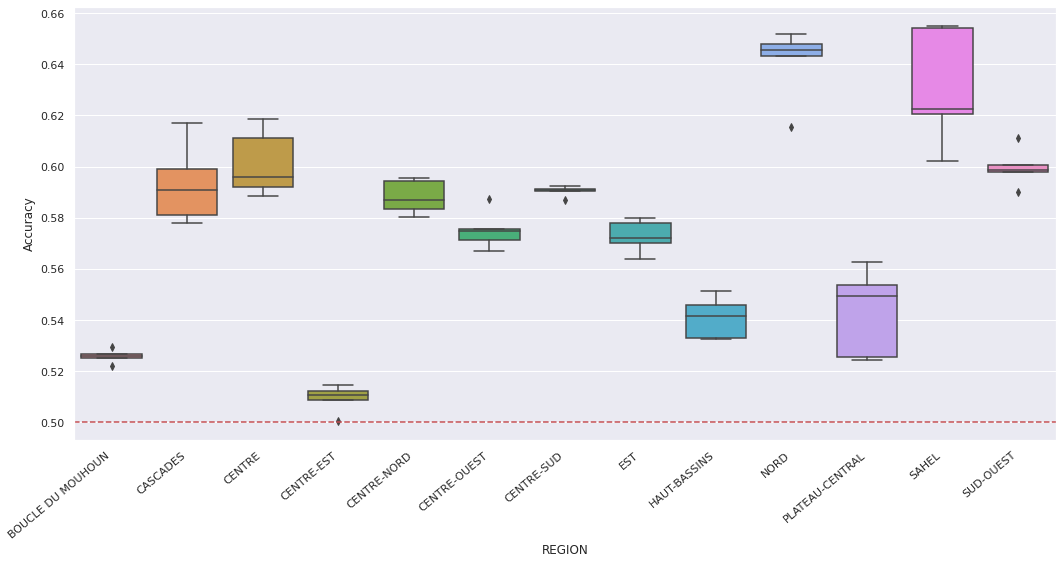

In [151]:
# Draw a vertical boxplot grouped 
# by a categorical variable:


sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(15,8)})
ax = sns.boxplot(x = 'REGION', y = 'Accuracy', data = df_result)

ax.axhline(0.5, ls='--',color='r')



ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

### Region en fonction de Region selon l'emplacement  <a class="anchor" id="#section_9_3"></a>

Juste avant nous avons parlé d'une difference entre les regions du nord et du Sud, on va donc essayer de predire la region SAHEL situé au nord du pays grace aux regions du sud a savoir "CASCADE" "SUD OUEST" et "HAUT BASSINS"

In [191]:

    ##Liste des nom de region
    nom_region = dataframe.REGION.unique().tolist()
    df_result = pd.DataFrame(columns=['REGION','Methode','Accuracy','Precision','Recall'])
    dataTra = dataframe[dataframe['REGION'] == "CENTRE-SUD"]
    dataTra_add =  dataframe[dataframe['REGION'] == "NORD"]
    
    dataTra = pd.concat([dataTra, dataTra_add])
 
    
 
   
    
    dataTest = dataframe[dataframe['REGION'] == "SAHEL"]
    
    print("train :",dataTra.REGION.unique().tolist())
    print("test :",dataTest.REGION.unique().tolist())
    x_train, y_train = dataTra[data_features].values, dataTra[data_label].values
    x_test , y_test = dataTest[data_features].values, dataTest[data_label].values
    
    print ('Training Set: %d, Test Set: %d \n' % (y_train.size, y_test.size))
    
### Classification ( x5 pour obtenir une moyenne avec ecart type)    
    for i in range(5):
       
        
        
###RANDOM CLASSIFIER

        clf = RandomForestClassifier()
        clf.fit(x_train, y_train)
        y_predictions = clf.predict(x_test)
        
        ###print(classification_report(y_test, y_predictions))
        accura = accuracy_score(y_test, y_predictions)
        preci =precision_score(y_test, y_predictions, average='macro')
        recall =recall_score(y_test, y_predictions, average='macro')
        ###print("Overall Accuracy:", "{:.2f}".format(accura))
        ###print("Overall Precision:","{:.2f}".format(preci))
        ###print("Overall Recall:","{:.2f}".format(recall))
        df_add= {'REGION' : "SAHEL", 
                'Methode' : "RandomClassif", 
                'Accuracy' : accura,
                'Precision' : preci,
                'Recall' : recall,
                }
        df_result = df_result.append(df_add, ignore_index = True)                                 

        
        ###print()
        ###mcm = confusion_matrix(y_test, y_predictions)
        ###print(mcm)
        ###print()"""

train : ['CENTRE-SUD', 'NORD']
test : ['SAHEL']
Training Set: 5940, Test Set: 2112 



In [192]:
df_result1 = df_result.groupby("REGION").mean()
df_result1

,Accuracy,Precision,Recall
REGION,,,
SAHEL,0.448106,0.424981,0.431624


In [193]:
mcm = confusion_matrix(y_test, y_predictions)
print(mcm)

[[254 694]
 [489 675]]


In [194]:
print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

           0       0.34      0.27      0.30       948
           1       0.49      0.58      0.53      1164

    accuracy                           0.44      2112
   macro avg       0.42      0.42      0.42      2112
weighted avg       0.43      0.44      0.43      2112



## Features : 

### Matrice de corrélation : 

Pour cette partie nous allons prendre les 5 features les plus corrélé avec le sca pour la prédiction 

In [195]:


data_label = 'Class_SCA'


data_features= dataframe[["NDVI", 'EVAPO','TMAX','LAILV','PLUIE','REGION_label',"PROVINCE_label","COMMUNE_label"]]
data_features = data_features.columns


In [196]:
##Liste des années
nom_region = dataframe.ANNEE.unique().tolist()
df_result = pd.DataFrame(columns=['REGION','Methode','Accuracy','Precision','Recall'])
dataTra = dataframe[dataframe['ANNEE'] == nom_region[0]]
dataTra_add = pd.DataFrame()

### Creation Train test en fonction des années
for j in range (1,len(nom_region)):
    
    print("#############################################",j,"/",len(nom_region)-1)
    if j != 1:
        dataTra_add =  dataframe[dataframe['ANNEE'] == nom_region[j-1]]
    
    dataTest = dataframe[dataframe['ANNEE'] == nom_region[j]]
    dataTra = pd.concat([dataTra, dataTra_add])
    print("train :",dataTra.ANNEE.unique().tolist())
    print("test :",dataTest.ANNEE.unique().tolist())
    x_train, y_train = dataTra[data_features].values, dataTra[data_label].values
    x_test , y_test = dataTest[data_features].values, dataTest[data_label].values
    print(nom_region[j])
    print ('Training Set: %d, Test Set: %d \n' % (y_train.size, y_test.size))
    
### Classification ( x5 pour obtenir une moyenne avec ecart type)    
    for i in range(5):
       
        
        
###RANDOM CLASSIFIER

        clf = RandomForestClassifier()
        clf.fit(x_train, y_train)
        y_predictions = clf.predict(x_test)
        
        ###print(classification_report(y_test, y_predictions))
        accura = accuracy_score(y_test, y_predictions)
        preci =precision_score(y_test, y_predictions, average='macro')
        recall =recall_score(y_test, y_predictions, average='macro')
        ###print("Overall Accuracy:", "{:.2f}".format(accura))
        ###print("Overall Precision:","{:.2f}".format(preci))
        ###print("Overall Recall:","{:.2f}".format(recall))
        df_add= {'REGION' : nom_region[j], 
                'Methode' : "RandomClassif", 
                'Accuracy' : accura,
                'Precision' : preci,
                'Recall' : recall,
                }
        df_result = df_result.append(df_add, ignore_index = True)                                 

        
        ###print()
        mcm = confusion_matrix(y_test, y_predictions)
        ##print(mcm)
        ###print()

############################################# 1 / 10
train : [2010]
test : [2011]
2011
Training Set: 3552, Test Set: 3552 

############################################# 2 / 10
train : [2010, 2011]
test : [2012]
2012
Training Set: 7104, Test Set: 3552 

############################################# 3 / 10
train : [2010, 2011, 2012]
test : [2013]
2013
Training Set: 10656, Test Set: 3552 

############################################# 4 / 10
train : [2010, 2011, 2012, 2013]
test : [2014]
2014
Training Set: 14208, Test Set: 3552 

############################################# 5 / 10
train : [2010, 2011, 2012, 2013, 2014]
test : [2015]
2015
Training Set: 17760, Test Set: 3552 

############################################# 6 / 10
train : [2010, 2011, 2012, 2013, 2014, 2015]
test : [2016]
2016
Training Set: 21312, Test Set: 3552 

############################################# 7 / 10
train : [2010, 2011, 2012, 2013, 2014, 2015, 2016]
test : [2017]
2017
Training Set: 24864, Test Set: 3552 

#

In [197]:
df_result1 = df_result.groupby("REGION").mean()
print(df_result1)

df_result_corré = df_result1

        Accuracy  Precision    Recall
REGION                               
2011    0.687444   0.668556  0.669986
2012    0.706363   0.678500  0.676235
2013    0.723142   0.687811  0.688782
2014    0.658333   0.637194  0.625051
2015    0.664752   0.664767  0.644427
2016    0.628660   0.685075  0.668049
2017    0.581926   0.641313  0.659888
2018    0.660417   0.682854  0.681528
2019    0.700000   0.708609  0.712622
2020    0.617286   0.617634  0.651530


In [198]:
duwu = df_result_corré.mean()
duwu

Accuracy     0.662832
Precision    0.667231
Recall       0.667810
dtype: float64

### Variance Inflation Factor

In [160]:
data_vif

,variables,VIF
0,VHI,38.941880
1,vci,39.420977
2,T,16164.246096
3,TMAX,8499.549359
4,TMIN,1866.549497
5,PLUIE,2.548907
6,EVAPO,222.385176
7,LAIHV,5.129926
8,LAILV,109.307154
9,NDVI,39.876142


In [161]:

data_label = 'Class_SCA'


data_features= dataframe[["NDVI",'EVAPO','LAIHV','PLUIE','REGION_label',"PROVINCE_label","COMMUNE_label"]]
data_features = data_features.columns

In [162]:
##Liste des années
nom_region = dataframe.ANNEE.unique().tolist()
df_result = pd.DataFrame(columns=['REGION','Methode','Accuracy','Precision','Recall'])
dataTra = dataframe[dataframe['ANNEE'] == nom_region[0]]
dataTra_add = pd.DataFrame()

### Creation Train test en fonction des années
for j in range (1,len(nom_region)):
    
    print("#############################################",j,"/",len(nom_region)-1)
    if j != 1:
        dataTra_add =  dataframe[dataframe['ANNEE'] == nom_region[j-1]]
    
    dataTest = dataframe[dataframe['ANNEE'] == nom_region[j]]
    dataTra = pd.concat([dataTra, dataTra_add])
    print("train :",dataTra.ANNEE.unique().tolist())
    print("test :",dataTest.ANNEE.unique().tolist())
    x_train, y_train = dataTra[data_features].values, dataTra[data_label].values
    x_test , y_test = dataTest[data_features].values, dataTest[data_label].values
    print(nom_region[j])
    print ('Training Set: %d, Test Set: %d \n' % (y_train.size, y_test.size))
    
### Classification ( x5 pour obtenir une moyenne avec ecart type)    
    for i in range(5):
       
        
        
###RANDOM CLASSIFIER

        clf = RandomForestClassifier()
        clf.fit(x_train, y_train)
        y_predictions = clf.predict(x_test)
        
        ###print(classification_report(y_test, y_predictions))
        accura = accuracy_score(y_test, y_predictions)
        preci =precision_score(y_test, y_predictions, average='macro')
        recall =recall_score(y_test, y_predictions, average='macro')
        ###print("Overall Accuracy:", "{:.2f}".format(accura))
        ###print("Overall Precision:","{:.2f}".format(preci))
        ###print("Overall Recall:","{:.2f}".format(recall))
        df_add= {'REGION' : nom_region[j], 
                'Methode' : "RandomClassif", 
                'Accuracy' : accura,
                'Precision' : preci,
                'Recall' : recall,
                }
        df_result = df_result.append(df_add, ignore_index = True)                                 

        
        ###print()
        mcm = confusion_matrix(y_test, y_predictions)
        ##print(mcm)
        ###print()

############################################# 1 / 10
train : [2010]
test : [2011]
2011
Training Set: 3552, Test Set: 3552 

############################################# 2 / 10
train : [2010, 2011]
test : [2012]
2012
Training Set: 7104, Test Set: 3552 

############################################# 3 / 10
train : [2010, 2011, 2012]
test : [2013]
2013
Training Set: 10656, Test Set: 3552 

############################################# 4 / 10
train : [2010, 2011, 2012, 2013]
test : [2014]
2014
Training Set: 14208, Test Set: 3552 

############################################# 5 / 10
train : [2010, 2011, 2012, 2013, 2014]
test : [2015]
2015
Training Set: 17760, Test Set: 3552 

############################################# 6 / 10
train : [2010, 2011, 2012, 2013, 2014, 2015]
test : [2016]
2016
Training Set: 21312, Test Set: 3552 

############################################# 7 / 10
train : [2010, 2011, 2012, 2013, 2014, 2015, 2016]
test : [2017]
2017
Training Set: 24864, Test Set: 3552 

#

In [163]:
df_result1 = df_result.groupby("REGION").mean()
print(df_result1)

df_result_VIF = df_result1

        Accuracy  Precision    Recall
REGION                               
2011    0.691667   0.674401  0.678070
2012    0.703941   0.679408  0.684615
2013    0.717736   0.683694  0.688907
2014    0.647410   0.626354  0.620616
2015    0.657827   0.654588  0.639837
2016    0.635755   0.681710  0.670811
2017    0.582376   0.632820  0.652603
2018    0.669144   0.685617  0.686918
2019    0.704955   0.713328  0.717523
2020    0.604899   0.611839  0.643944


In [164]:
duwu = df_result_VIF.mean()
duwu

Accuracy     0.661571
Precision    0.664376
Recall       0.668384
dtype: float64

### PCA

In [165]:
finalDf

,principal component 1,principal component 2,Class_SCA,REGION,ANNEE
0,-143.341654,22.673384,1,BOUCLE DU MOUHOUN,2010
1,-143.340180,22.634927,1,BOUCLE DU MOUHOUN,2010
2,-143.338979,22.606217,1,BOUCLE DU MOUHOUN,2010
3,-143.338942,22.601191,1,BOUCLE DU MOUHOUN,2010
4,-143.343695,22.691510,1,BOUCLE DU MOUHOUN,2010
...,...,...,...,...,...
39067,60.401613,-10.424864,0,SUD-OUEST,2020
39068,60.408852,-10.556027,0,SUD-OUEST,2020
39069,60.407736,-10.513555,0,SUD-OUEST,2020
39070,60.419661,-10.844565,0,SUD-OUEST,2020


In [166]:

data_label = 'Class_SCA'


data_features= finalDf[["principal component 1", 'principal component 2']]
data_features = data_features.columns

In [167]:
##Liste des années
nom_region = finalDf.ANNEE.unique().tolist()
df_result = pd.DataFrame(columns=['REGION','Methode','Accuracy','Precision','Recall'])
dataTra = finalDf[finalDf['ANNEE'] == nom_region[0]]
dataTra_add = pd.DataFrame()

### Creation Train test en fonction des années
for j in range (1,len(nom_region)):
    
    print("#############################################",j,"/",len(nom_region)-1)
    if j != 1:
        dataTra_add =  finalDf[finalDf['ANNEE'] == nom_region[j-1]]
    
    dataTest = finalDf[finalDf['ANNEE'] == nom_region[j]]
    dataTra = pd.concat([dataTra, dataTra_add])
    print("train :",dataTra.ANNEE.unique().tolist())
    print("test :",dataTest.ANNEE.unique().tolist())
    x_train, y_train = dataTra[data_features].values, dataTra[data_label].values
    x_test , y_test = dataTest[data_features].values, dataTest[data_label].values
    print(nom_region[j])
    print ('Training Set: %d, Test Set: %d \n' % (y_train.size, y_test.size))
    
### Classification ( x5 pour obtenir une moyenne avec ecart type)    
    for i in range(5):
       
        
        
###RANDOM CLASSIFIER

        clf = RandomForestClassifier()
        clf.fit(x_train, y_train)
        y_predictions = clf.predict(x_test)
        
        ###print(classification_report(y_test, y_predictions))
        accura = accuracy_score(y_test, y_predictions)
        preci =precision_score(y_test, y_predictions, average='macro')
        recall =recall_score(y_test, y_predictions, average='macro')
        ###print("Overall Accuracy:", "{:.2f}".format(accura))
        ###print("Overall Precision:","{:.2f}".format(preci))
        ###print("Overall Recall:","{:.2f}".format(recall))
        df_add= {'REGION' : nom_region[j], 
                'Methode' : "RandomClassif", 
                'Accuracy' : accura,
                'Precision' : preci,
                'Recall' : recall,
                }
        df_result = df_result.append(df_add, ignore_index = True)                                 

        
        ###print()
        mcm = confusion_matrix(y_test, y_predictions)
        ##print(mcm)
        ###print()

############################################# 1 / 10
train : [2010]
test : [2011]
2011
Training Set: 3552, Test Set: 3552 

############################################# 2 / 10
train : [2010, 2011]
test : [2012]
2012
Training Set: 7104, Test Set: 3552 

############################################# 3 / 10
train : [2010, 2011, 2012]
test : [2013]
2013
Training Set: 10656, Test Set: 3552 

############################################# 4 / 10
train : [2010, 2011, 2012, 2013]
test : [2014]
2014
Training Set: 14208, Test Set: 3552 

############################################# 5 / 10
train : [2010, 2011, 2012, 2013, 2014]
test : [2015]
2015
Training Set: 17760, Test Set: 3552 

############################################# 6 / 10
train : [2010, 2011, 2012, 2013, 2014, 2015]
test : [2016]
2016
Training Set: 21312, Test Set: 3552 

############################################# 7 / 10
train : [2010, 2011, 2012, 2013, 2014, 2015, 2016]
test : [2017]
2017
Training Set: 24864, Test Set: 3552 

#

In [168]:
df_result1 = df_result.groupby("REGION").mean()
print(df_result1)

df_result_PCA = df_result1

        Accuracy  Precision    Recall
REGION                               
2011    0.691892   0.674821  0.678746
2012    0.716385   0.694717  0.703620
2013    0.713739   0.681147  0.689269
2014    0.639752   0.618533  0.614167
2015    0.639809   0.633083  0.625302
2016    0.625113   0.662604  0.656294
2017    0.582095   0.628154  0.648266
2018    0.664977   0.676960  0.679770
2019    0.698480   0.702487  0.707544
2020    0.580743   0.586060  0.610803


In [169]:
duwu = df_result_PCA.mean()
duwu

Accuracy     0.655298
Precision    0.655856
Recall       0.661378
dtype: float64

### Random forest importance

In [170]:
final_df_p = final_df
final_df_p['Importances'] =  final_df_p['Importances'] * 100
final_df_p

,Features,Importances
0,REGION_label,4.323573
1,PLUIE,4.760010
2,LAILV,6.159773
3,T,6.302338
4,SOILT,6.483883
5,TMAX,6.598257
6,TMIN,6.666413
7,EVAPO,6.829263
8,vci,6.839003
9,TCI,7.014206


In [171]:

data_label = 'Class_SCA'


data_features= dataframe[["LAIHV","NDVI","VHI","TCI","vci",'REGION_label',"PROVINCE_label","COMMUNE_label"]]
data_features = data_features.columns

In [172]:
##Liste des années
nom_region = dataframe.ANNEE.unique().tolist()
df_result = pd.DataFrame(columns=['REGION','Methode','Accuracy','Precision','Recall'])
dataTra = dataframe[dataframe['ANNEE'] == nom_region[0]]
dataTra_add = pd.DataFrame()

### Creation Train test en fonction des années
for j in range (1,len(nom_region)):
    
    print("#############################################",j,"/",len(nom_region)-1)
    if j != 1:
        dataTra_add =  dataframe[dataframe['ANNEE'] == nom_region[j-1]]
    
    dataTest = dataframe[dataframe['ANNEE'] == nom_region[j]]
    dataTra = pd.concat([dataTra, dataTra_add])
    print("train :",dataTra.ANNEE.unique().tolist())
    print("test :",dataTest.ANNEE.unique().tolist())
    x_train, y_train = dataTra[data_features].values, dataTra[data_label].values
    x_test , y_test = dataTest[data_features].values, dataTest[data_label].values
    print(nom_region[j])
    print ('Training Set: %d, Test Set: %d \n' % (y_train.size, y_test.size))
    
### Classification ( x5 pour obtenir une moyenne avec ecart type)    
    for i in range(5):
       
        
        
###RANDOM CLASSIFIER

        clf = RandomForestClassifier()
        clf.fit(x_train, y_train)
        y_predictions = clf.predict(x_test)
        
        ###print(classification_report(y_test, y_predictions))
        accura = accuracy_score(y_test, y_predictions)
        preci =precision_score(y_test, y_predictions, average='macro')
        recall =recall_score(y_test, y_predictions, average='macro')
        ###print("Overall Accuracy:", "{:.2f}".format(accura))
        ###print("Overall Precision:","{:.2f}".format(preci))
        ###print("Overall Recall:","{:.2f}".format(recall))
        df_add= {'REGION' : nom_region[j], 
                'Methode' : "RandomClassif", 
                'Accuracy' : accura,
                'Precision' : preci,
                'Recall' : recall,
                }
        df_result = df_result.append(df_add, ignore_index = True)                                 

        
        ###print()
        mcm = confusion_matrix(y_test, y_predictions)
        ##print(mcm)
        ###print()

############################################# 1 / 10
train : [2010]
test : [2011]
2011
Training Set: 3552, Test Set: 3552 

############################################# 2 / 10
train : [2010, 2011]
test : [2012]
2012
Training Set: 7104, Test Set: 3552 

############################################# 3 / 10
train : [2010, 2011, 2012]
test : [2013]
2013
Training Set: 10656, Test Set: 3552 

############################################# 4 / 10
train : [2010, 2011, 2012, 2013]
test : [2014]
2014
Training Set: 14208, Test Set: 3552 

############################################# 5 / 10
train : [2010, 2011, 2012, 2013, 2014]
test : [2015]
2015
Training Set: 17760, Test Set: 3552 

############################################# 6 / 10
train : [2010, 2011, 2012, 2013, 2014, 2015]
test : [2016]
2016
Training Set: 21312, Test Set: 3552 

############################################# 7 / 10
train : [2010, 2011, 2012, 2013, 2014, 2015, 2016]
test : [2017]
2017
Training Set: 24864, Test Set: 3552 

#

In [173]:
df_result1 = df_result.groupby("REGION").mean()
print(df_result1)

df_result_RFI = df_result1

        Accuracy  Precision    Recall
REGION                               
2011    0.685191   0.666896  0.669397
2012    0.707207   0.681275  0.683679
2013    0.724268   0.689368  0.691083
2014    0.671340   0.652138  0.640062
2015    0.666779   0.664234  0.649418
2016    0.640653   0.690002  0.677096
2017    0.572635   0.628880  0.646488
2018    0.669651   0.689581  0.689467
2019    0.717399   0.724546  0.729356
2020    0.597635   0.611259  0.642855


In [174]:
duwu = df_result_RFI.mean()
duwu

Accuracy     0.665276
Precision    0.669818
Recall       0.671890
dtype: float64

### Classification multiclasse 

In [175]:
q1 = np.quantile(dataframe['SCA'],0.25)
print("Q1 SCA est de : ",q1)
mediane = np.quantile(dataframe['SCA'],0.5)
print("La mediane du SCA est de : ",mediane)
q3 = np.quantile(dataframe['SCA'],0.75)
print("Q3 SCA est de : ",q3)

Q1 SCA est de :  48.41666666666666
La mediane du SCA est de :  59.45416666666667
Q3 SCA est de :  70.3716856060606


In [176]:
### On parcours le dataset pour definir l'appartenance a la classe 0 ou 1 

dataframe['Class_SCA'] = 0

for i in range(len(dataframe)):
    if dataframe['SCA'][i] < q1:
        dataframe['Class_SCA'][i] = 0
    if (dataframe['SCA'][i] > q1) and (dataframe['SCA'][i] < mediane):
        dataframe['Class_SCA'][i] = 1
    if (dataframe['SCA'][i] < q3) and (dataframe['SCA'][i] > mediane):
        dataframe['Class_SCA'][i] = 2
    if (dataframe['SCA'][i] > q3):
        dataframe['Class_SCA'][i] = 3
        



/home/yonas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/yonas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/yonas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__

In [177]:
##Defini nos features et nos label pour la sutie

data_features = dataframe
data_features =  data_features.drop('REGION', 1)
data_features =  data_features.drop('COMMUNE', 1)
data_features =  data_features.drop('PROVINCE', 1)
data_features =  data_features.drop('SCA', 1)
data_features =  data_features.drop('SDA', 1)
data_features =  data_features.drop('Class_SCA', 1)
data_features =  data_features.drop('Class_SDA', 1)
data_features =  data_features.drop('ADD_PRED', 1)

data_label = 'Class_SCA'

data_features = data_features.columns
data_features

Index(['ANNEE', 'MOIS', 'VHI', 'vci', 'T', 'TMAX', 'TMIN', 'PLUIE', 'EVAPO',
       'LAIHV', 'LAILV', 'NDVI', 'TCI', 'SOILT', 'REGION_label',
       'PROVINCE_label', 'COMMUNE_label'],
      dtype='object')

In [178]:
##Liste des années
nom_region = dataframe.ANNEE.unique().tolist()
df_result = pd.DataFrame(columns=['REGION','Methode','Accuracy','Precision','Recall'])
dataTra = dataframe[dataframe['ANNEE'] == nom_region[0]]
dataTra_add = pd.DataFrame()

### Creation Train test en fonction des années
for j in range (1,len(nom_region)):
    
    print("#############################################",j,"/",len(nom_region)-1)
    if j != 1:
        dataTra_add =  dataframe[dataframe['ANNEE'] == nom_region[j-1]]
    
    dataTest = dataframe[dataframe['ANNEE'] == nom_region[j]]
    dataTra = pd.concat([dataTra, dataTra_add])
    print("train :",dataTra.ANNEE.unique().tolist())
    print("test :",dataTest.ANNEE.unique().tolist())
    x_train, y_train = dataTra[data_features].values, dataTra[data_label].values
    x_test , y_test = dataTest[data_features].values, dataTest[data_label].values
    print(nom_region[j])
    print ('Training Set: %d, Test Set: %d \n' % (y_train.size, y_test.size))
    
### Classification ( x5 pour obtenir une moyenne avec ecart type)    
    for i in range(5):
       
        
        
###RANDOM CLASSIFIER

        clf = RandomForestClassifier()
        clf.fit(x_train, y_train)
        y_predictions = clf.predict(x_test)
        
        ###print(classification_report(y_test, y_predictions))
        accura = accuracy_score(y_test, y_predictions)
        preci =precision_score(y_test, y_predictions, average='macro')
        recall =recall_score(y_test, y_predictions, average='macro')
        ###print("Overall Accuracy:", "{:.2f}".format(accura))
        ###print("Overall Precision:","{:.2f}".format(preci))
        ###print("Overall Recall:","{:.2f}".format(recall))
        df_add= {'REGION' : nom_region[j], 
                'Methode' : "RandomClassif", 
                'Accuracy' : accura,
                'Precision' : preci,
                'Recall' : recall,
                }
        df_result = df_result.append(df_add, ignore_index = True)                                 

        
        ###print()
        mcm = confusion_matrix(y_test, y_predictions)
        ##print(mcm)
        ##print()

############################################# 1 / 10
train : [2010]
test : [2011]
2011
Training Set: 3552, Test Set: 3552 

############################################# 2 / 10
train : [2010, 2011]
test : [2012]
2012
Training Set: 7104, Test Set: 3552 

############################################# 3 / 10
train : [2010, 2011, 2012]
test : [2013]
2013
Training Set: 10656, Test Set: 3552 

############################################# 4 / 10
train : [2010, 2011, 2012, 2013]
test : [2014]
2014
Training Set: 14208, Test Set: 3552 

############################################# 5 / 10
train : [2010, 2011, 2012, 2013, 2014]
test : [2015]
2015
Training Set: 17760, Test Set: 3552 

############################################# 6 / 10
train : [2010, 2011, 2012, 2013, 2014, 2015]
test : [2016]
2016
Training Set: 21312, Test Set: 3552 

############################################# 7 / 10
train : [2010, 2011, 2012, 2013, 2014, 2015, 2016]
test : [2017]
2017
Training Set: 24864, Test Set: 3552 

#

In [179]:
print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

           0       0.74      0.59      0.66      1620
           1       0.33      0.27      0.30       996
           2       0.20      0.21      0.20       600
           3       0.19      0.47      0.27       336

    accuracy                           0.42      3552
   macro avg       0.37      0.38      0.36      3552
weighted avg       0.48      0.42      0.44      3552



In [180]:
df_result1 = df_result.groupby("REGION").mean()
print(df_result1)

df_result_multiclasse = df_result1

        Accuracy  Precision    Recall
REGION                               
2011    0.398423   0.404694  0.396521
2012    0.512500   0.500274  0.499902
2013    0.482658   0.463177  0.454618
2014    0.423761   0.393172  0.387974
2015    0.456700   0.460180  0.441319
2016    0.445552   0.471692  0.465916
2017    0.464189   0.423963  0.444814
2018    0.552140   0.527861  0.498672
2019    0.659797   0.635181  0.624788
2020    0.429730   0.371844  0.389477


In [181]:
duwu = df_result_multiclasse.mean()
duwu

Accuracy     0.482545
Precision    0.465204
Recall       0.460400
dtype: float64